In [1]:
#IMPORT SOME BASIC LIBRARIES 
import requests
import json
import torch
import os
from tqdm import tqdm


from pathlib import Path
from torch.utils.data import DataLoader
import time

In [2]:
import json
with open(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/data/data qna/data_individual/with_dupli/proc_train_full.json", "r") as read_file:
    full = json.load(read_file)

In [3]:
len(full)

2603

In [4]:
from sklearn.model_selection import train_test_split

train, _ = train_test_split(full, test_size=0.30, random_state=42)
valid, test = train_test_split(_, test_size=0.50, random_state=42)


In [5]:
len(train), len(valid), len(test)

(1822, 390, 391)

In [8]:
torch.__version__

'1.10.1'

In [9]:
def read_data(squad):


    contexts = []
    questions = []
    answers = []

    for group in squad:
    # for passage in group['paragraphs']:
        context = group['context']
        print()
        for qa in group['qas']:
            question = qa['question']
            for answer in qa['answers']:
                contexts.append(context)
                questions.append(question)
                answers.append(answer)

    return contexts, questions, answers

In [10]:

train_contexts, train_questions, train_answers = read_data(train)
valid_contexts, valid_questions, valid_answers = read_data(valid)
test_contexts, test_questions, test_answers = read_data(test)

In [11]:
len(train_contexts), len(train_answers),len(train_questions)

(3270, 3270, 3270)

In [12]:
len(valid_answers), len(valid_contexts), len(valid_questions)

(695, 695, 695)

In [13]:
train_contexts[1], train_questions[1], train_answers[1]

('Fast fashion trends lead to significant quantities of textiles produced and discarded, its waste is incinerated or landfilled due to a lack of recycling technologies for mixed textiles. Recycling of mixed textiles by hydrothermal liquefaction (HTL) is a novel approach to produce bio-oil and monomers, as no prior sorting or color removal is required. Herein, post-consumer polyester (polyethylene terephthalate (PET)) and cotton garments were subjected to HTL to produce bio-oil and terephthalic acid (TPA). The effects of blending ratio of PET and cotton, temperature and alkali catalyst on the product distributions are investigated. A maximum bio-oil yield of 26% was attained at 325 °C for a 95% Cotton/ 5% PET mix under alkali conditions. TPA yields ranged from 48 to 91%, where 50/50% PET/cotton resulted in a higher TPA yield than 95/5% PET/cotton textile wastes. The results obtained contribute to the development of sustainable recycling processes of mixed textiles.',
 'What are the proc

In [14]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two so we fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters
        else:
            answer['answer_end'] = end_idx

add_end_idx(train_answers, train_contexts)
add_end_idx(valid_answers, valid_contexts)
add_end_idx(test_answers, test_contexts)

In [15]:
# You can see that now we get the answer_end also
print(train_questions[-10])
print(train_answers[-10])
print(train_contexts[-10])

What are the process conditions?
{'text': '35.83 MPa', 'answer_start': 841, 'answer_end': 850}
Polypropylene fiber (PPF) is often added to improve the mechanical properties of concrete in engineering applications. As a material used extensively in the textile industry, a huge amount of discarded polypropylene fabrics (PPFF) are produced each year. This study used the waste PPFF as the research object to investigate the feasibility of replacing PPF as concrete admixture on the basis of the concept of green environmental protection. The mechanical properties of polypropylene fiber fabric-reinforced concrete (PPFFRC) with five different fabric contents of 0–1.5 kg/m3 under three different curing ages of 14–60 days were tested. Results show that the dosage of 0.9 kg/m3 PPFF is the best. Compared with the polypropylene fiber reinforced concrete with the same dosage at the age of 60 days, the compressive strength increased from 35.83 MPa to 42.83 MPa, the flexural strength increased from 5.9

In [16]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


# from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

#model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True)

In [17]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [18]:
no_of_encodings = len(valid_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 695 context-question pairs


In [19]:
no_of_encodings = len(test_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 727 context-question pairs


In [20]:
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 3270 context-question pairs


In [21]:
print(train_encodings['input_ids'][0])

[101, 2320, 3718, 2013, 1996, 2712, 1010, 2070, 26166, 3685, 2022, 22207, 2030, 26513, 1012, 2023, 11385, 2038, 2152, 10250, 10050, 8873, 2278, 3643, 2029, 3084, 2009, 7218, 2000, 2224, 2004, 4762, 1012, 2005, 2023, 3114, 1010, 1037, 8150, 1997, 6081, 4475, 2001, 13532, 2000, 18479, 23367, 6351, 3989, 2478, 2712, 5880, 2004, 23735, 1012, 2057, 2071, 2947, 11628, 1996, 6459, 1997, 1996, 2345, 3688, 4663, 1998, 3231, 1996, 24010, 1997, 16401, 3884, 6081, 11385, 2046, 4762, 1012, 3463, 3662, 2008, 6274, 1996, 4860, 1997, 1996, 2832, 4359, 1996, 28256, 2019, 8496, 4180, 1998, 3445, 18479, 7507, 2099, 13316, 2615, 1012, 1999, 2804, 1010, 1996, 10867, 16429, 7911, 5897, 2001, 2109, 2000, 2298, 2005, 5966, 1999, 1996, 9829, 22511, 1997, 1996, 2367, 5024, 22644, 1010, 2108, 18479, 7507, 2099, 2012, 3998, 6362, 1996, 2087, 5360, 3430, 1012, 1996, 4180, 1997, 28256, 10099, 1999, 1996, 1044, 13535, 1011, 13207, 7457, 2004, 1996, 2832, 4860, 3123, 1012, 13463, 2229, 1010, 6544, 2015, 1998, 2632, 9

In [22]:
tokenizer.decode(train_encodings['input_ids'][0])

'[CLS] once removed from the sea, some plastics cannot be recycled or reused. this debris has high calorific value which makes it suitable to use as fuel. for this reason, a mixture of plastic materials was subjected to hydrothermal carbonization using seawater as solvent. we could thus examine the characteristics of the final products obtained and test the feasibility of converting marine plastic debris into fuel. results showed that raising the temperature of the process reduced the inorganic anions content and increased hydrochar ncv. in addition, thermobalance was used to look for differences in the thermal decomposition of the different solid residues, being hydrochar at 300 °c the most affected material. the content of inorganic compounds in the htc - liquor increases as the process temperature rose. amides, alcohols and alkanes were the main organic compounds found in all cases. gases emissions also increased with temperature. [SEP] what are the process conditions? [SEP] [PAD] [

In [23]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # print(i)
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # print(i)

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

        encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [24]:
add_token_positions(train_encodings, train_answers)
add_token_positions(valid_encodings, valid_answers)
add_token_positions(test_encodings, test_answers)

In [25]:
train_encodings['start_positions'][:10]

[512, 153, 512, 316, 319, 512, 512, 319, 342, 96]

# Dataset definition 🗄️
We have to define our dataset using the PyTorch Dataset class from torch.utils in order create our dataloaders after that.

In [26]:
class SQuAD_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [27]:
train_dataset = SQuAD_Dataset(train_encodings)
valid_dataset = SQuAD_Dataset(valid_encodings)
test_dataset  = SQuAD_Dataset(test_encodings)

**Dataloader**

In [29]:
from torch.utils.data import DataLoader

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)
test_loader  = DataLoader(test_dataset, batch_size=8)

# Load pretrained bert
We are going to use the bert-case-uncased from the huggingface transformers.

In [30]:
from transformers import BertForQuestionAnswering

#model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

In [32]:
# Check on the available device - use GPU
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

Working on cuda:0


In [33]:
from transformers import AdamW
import torch.nn as nn

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
epochs = 10
# epochs = 4

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [34]:
val_loader = valid_loader

In [35]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 10

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()

    loss_of_epoch = 0

    print("############Train############")

    for batch_idx,batch in enumerate(train_loader): 

        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # do a backwards pass 
        loss.backward()
        # update the weights
        optim.step()
        # Find the total loss
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ##########Evaluation##################

    # Set model in evaluation mode
    model.eval()

    print("############Evaluate############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Find the total loss
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss 
    print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 10 / 409 
Loss: 2.0 

Batch 20 / 409 
Loss: 1.5 

Batch 30 / 409 
Loss: 1.3 

Batch 40 / 409 
Loss: 1.1 

Batch 50 / 409 
Loss: 1.5 

Batch 60 / 409 
Loss: 0.9 

Batch 70 / 409 
Loss: 1.1 

Batch 80 / 409 
Loss: 2.5 

Batch 90 / 409 
Loss: 1.2 

Batch 100 / 409 
Loss: 0.8 

Batch 110 / 409 
Loss: 0.8 

Batch 120 / 409 
Loss: 1.7 

Batch 130 / 409 
Loss: 1.2 

Batch 140 / 409 
Loss: 1.3 

Batch 150 / 409 
Loss: 1.0 

Batch 160 / 409 
Loss: 1.1 

Batch 170 / 409 
Loss: 1.8 

Batch 180 / 409 
Loss: 1.3 

Batch 190 / 409 
Loss: 1.3 

Batch 200 / 409 
Loss: 1.4 

Batch 210 / 409 
Loss: 1.3 

Batch 220 / 409 
Loss: 1.0 

Batch 230 / 409 
Loss: 0.8 

Batch 240 / 409 
Loss: 1.1 

Batch 250 / 409 
Loss: 1.5 

Batch 260 / 409 
Loss: 1.3 

Batch 270 / 409 
Loss: 1.0 

Batch 280 / 409 
Loss: 1.3 

Batch 290 / 409 
Loss: 1.4 

Batch 300 / 409 
Loss: 0.6 

Batch 310 / 409 
Loss: 0.7 

Batch 320 / 409 
Loss: 0.9 

Batch 330 / 409 
Loss: 1.4 

Batch 340 / 409 
Loss:

Batch 110 / 409 
Loss: 1.1 

Batch 120 / 409 
Loss: 0.4 

Batch 130 / 409 
Loss: 0.8 

Batch 140 / 409 
Loss: 1.0 

Batch 150 / 409 
Loss: 0.8 

Batch 160 / 409 
Loss: 0.7 

Batch 170 / 409 
Loss: 0.8 

Batch 180 / 409 
Loss: 0.6 

Batch 190 / 409 
Loss: 1.0 

Batch 200 / 409 
Loss: 1.0 

Batch 210 / 409 
Loss: 0.6 

Batch 220 / 409 
Loss: 0.8 

Batch 230 / 409 
Loss: 0.8 

Batch 240 / 409 
Loss: 1.1 

Batch 250 / 409 
Loss: 0.6 

Batch 260 / 409 
Loss: 0.8 

Batch 270 / 409 
Loss: 0.6 

Batch 280 / 409 
Loss: 0.9 

Batch 290 / 409 
Loss: 0.9 

Batch 300 / 409 
Loss: 0.5 

Batch 310 / 409 
Loss: 0.8 

Batch 320 / 409 
Loss: 0.7 

Batch 330 / 409 
Loss: 0.6 

Batch 340 / 409 
Loss: 1.2 

Batch 350 / 409 
Loss: 0.7 

Batch 360 / 409 
Loss: 1.1 

Batch 370 / 409 
Loss: 0.3 

Batch 380 / 409 
Loss: 0.7 

Batch 390 / 409 
Loss: 0.9 

Batch 400 / 409 
Loss: 1.2 

############Evaluate############
Batch 10 / 87 
Loss: 1.5 

Batch 20 / 87 
Loss: 0.6 

Batch 30 / 87 
Loss: 1.0 

Batch 40 / 87 
L

# Step 12: Plot train and validation losses¶


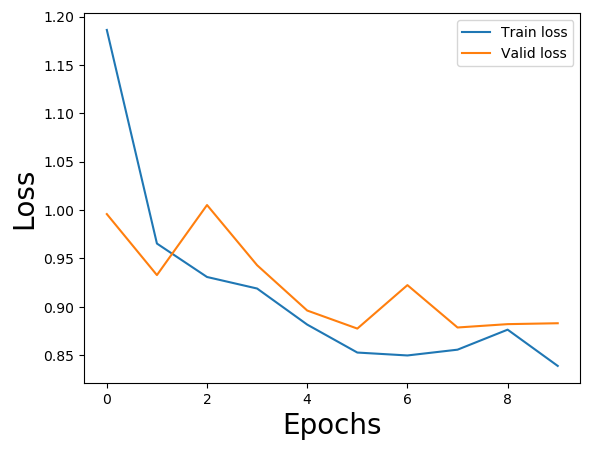

In [84]:
import matplotlib.pyplot as plt 
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
#plt.title("Train and Validation Losses",size=20)
plt.legend(['Train loss',"Valid loss"])
plt.savefig("/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/process/learning_with_question_ansered.pdf", bbox_inches="tight",
             pad_inches=0.3, transparent=True)
plt.show()

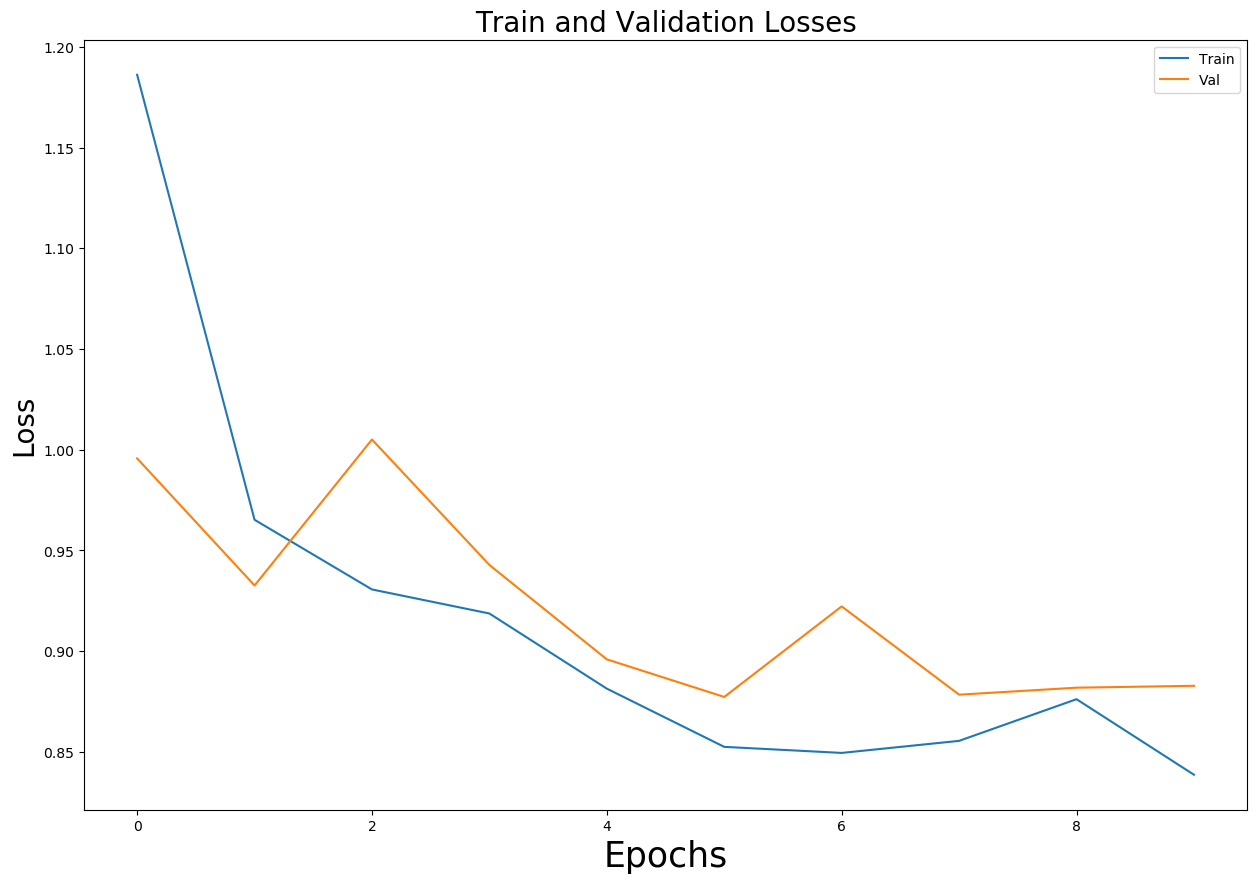

In [38]:

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

**Save the model in my drive in order not to run it each time**

In [83]:
model_path = "/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/pretrained_model/new_trained_model/proc_with_question_ansered/"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/pretrained_model/new_trained_model/proc_with_question_ansered/tokenizer_config.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/pretrained_model/new_trained_model/proc_with_question_ansered/special_tokens_map.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/pretrained_model/new_trained_model/proc_with_question_ansered/vocab.txt',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/pretrained_model/new_trained_model/proc_with_question_ansered/added_tokens.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/pretrained_model/new_trained_model/proc_with_question_ansered/tokenizer.json')

# Test
We are evaluating the model on the validation set by checking the model's predictions for the answer's start and end indexes and comparing with the true ones.

In [44]:
model.eval()

acc = []

for batch in tqdm(valid_loader):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)

        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

acc = sum(acc)/len(acc)

print("\n\nT/P\tanswer_start\tanswer_end\n")
for i in range(len(start_true)):
    print(f"true\t{start_true[i]}\t{end_true[i]}\n"
        f"pred\t{start_pred[i]}\t{end_pred[i]}\n")

100%|██████████████████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]



T/P	answer_start	answer_end

true	62	64
pred	62	54

true	66	70
pred	62	54

true	183	185
pred	62	54

true	198	202
pred	62	54

true	512	512
pred	109	110

true	169	172
pred	169	172

true	212	215
pred	212	215

true	228	229
pred	212	215

true	512	512
pred	84	82

true	512	512
pred	84	82

true	512	512
pred	84	82



# Data load for testing

# Ask question
We are going to use some functions from the official Evaluation Script v2.0 of SQuAD in order to test the fine-tuned model by asking some questions given a context. I have also looked at this notebook which evaluates BERT on SQuAD.

**Respectively, load the saved model**

In [6]:
from transformers import BertForQuestionAnswering, BertTokenizerFast

model_path = "/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/pretrained_model/new_trained_model/proc_only_2/"
model = BertForQuestionAnswering.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

model = model.to(device)

Working on cuda:0


In [7]:
##data list
context = []
answerss = []
question =[]

#loop data points
def extractquestions(test):
    for trai in test:
        context.append(trai['context'])
        question.append(trai['qas'][0]['question'])

    for sample in test:
        gold_answers = []
        for ans in sample['qas'][0]['answers']:
            gold_answers.append(ans['text'])
        answerss.append(gold_answers)
        
    return context, answerss, question

In [8]:
context, answerss, question = extractquestions(train)


In [9]:
len(context), len(train)

(1822, 1822)

In [19]:
F1 = []
preci = []
recal = []

In [11]:
def get_prediction_f1_0(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)
        start_logits = outputs[0]
        end_logits = outputs[1]

        def to_list(tensor):
            return tensor.detach().cpu().tolist()

        # convert our start and end logit tensors to lists
        start_logits = to_list(start_logits)[0]
        end_logits = to_list(end_logits)[0]

        # sort our start and end logits from largest to smallest, keeping track of the index
        start_idx_and_logit = sorted(enumerate(start_logits), key=lambda x: x[1], reverse=True)
        end_idx_and_logit = sorted(enumerate(end_logits), key=lambda x: x[1], reverse=True)

        # select the top n (in this case, 5)
#         print(start_idx_and_logit[:5])
#         print(end_idx_and_logit[:5]) 

        start_indexes = [idx for idx, logit in start_idx_and_logit[:5]]
        end_indexes = [idx for idx, logit in end_idx_and_logit[:5]]

        # convert the token ids from a tensor to a list
        tokens = to_list(inputs['input_ids'])[0]

        # question tokens are defined as those between the CLS token (101, at position 0) and first SEP (102) token 
        question_indexes = [i+1 for i, token in enumerate(tokens[1:tokens.index(102)])]

        import collections

        # keep track of all preliminary predictions
        PrelimPrediction = collections.namedtuple( 
            "PrelimPrediction", ["start_index", "end_index", "start_logit", "end_logit"]
        )

        prelim_preds = []
        for start_index in start_indexes:
            for end_index in end_indexes:
                # throw out invalid predictions
                if start_index in question_indexes:
                    continue
                if end_index in question_indexes:
                    continue
                if end_index < start_index:
                    continue
                prelim_preds.append(
                    PrelimPrediction(
                        start_index = start_index,
                        end_index = end_index,
                        start_logit = start_logits[start_index],
                        end_logit = end_logits[end_index]
                    )
                )

        # sort preliminary predictions by their score
        prelim_preds = sorted(prelim_preds, key=lambda x: (x.start_logit + x.end_logit), reverse=True)

        # keep track of all best predictions
        BestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
            "BestPrediction", ["text", "start_logit", "end_logit"]
        )

        nbest = []
        nbest_text =[]
        seen_predictions = []
        for pred in prelim_preds:

            # for now we only care about the top 5 best predictions
            if len(nbest) >= 5: 
                break

            # loop through predictions according to their start index
            if pred.start_index > 0: # non-null answers have start_index > 0

                text = tokenizer.convert_tokens_to_string(
                    tokenizer.convert_ids_to_tokens(
                        tokens[pred.start_index:pred.end_index+1]
                    )
                )
                # clean whitespace
                text = text.strip()
                text = " ".join(text.split())

                if text in seen_predictions:
                    continue

                # flag this text as being seen -- if we see it again, don't add it to the nbest list
                seen_predictions.append(text) 

                # add this text prediction to a pruned list of the top 5 best predictions
                nbest.append(BestPrediction(text=text, start_logit=pred.start_logit, end_logit=pred.end_logit))

        # and don't forget -- include the null answer!
        nbest.append(BestPrediction(text="", start_logit=start_logits[0], end_logit=end_logits[0]))

    except:
        print('no available')
        
        answer = "Nothing"
        
        seen_predictions = ["nothings"]
        
#     # Python code to remove whitespace
#     def remove(answer):
#         answer = 
#         return answer

    return seen_predictions

In [12]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [13]:
def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [14]:
def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

In [15]:
def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return round(2 * (prec * rec) / (prec + rec), 2)

In [18]:
def question_answer(context, question,answerss):
    prediction = get_prediction_f1_0(context,question)
    #em_score = exact_match(prediction, answer)
    #f1_score = compute_f1(prediction, answer)
    temp_f1 = [0,0]
    for pre in prediction:
        
        print(answerss, pre)

        if len(answerss) != 0:
            
            em_score = max((exact_match(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)
            f1_score = max((compute_f1(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)
            
            print(f1_score)
            temp_f1.append(f1_score)
    
        else:
            em_score = 0
            f1_score = 0
            temp_f1 = [0]
            
    #if max(temp_f1) <=1.0:
        
    if max(temp_f1) == 1.0:
        F1.append(max(temp_f1))
        
    elif max(temp_f1) != 1.0:
        for pre in prediction:
            print(answerss, pre)

            if len(answerss) != 0:
                em_score = max((exact_match(pre, answer)) for answer in answerss)
        #         for answer in answerss:
        #             presion, recall = comput_prec_recall(prediction, answer.replace(" ", ""))
        # #         presion, recall = max((comput_prec_recall(prediction, answer)) for answer in answerss)
        #         print(presion, recall)

                f1_score = max((compute_f1(pre, answer)) for answer in answerss)
                print(f1_score)
        #         if f1_score == 1.0:
                temp_f1.append(f1_score)
            else:
                em_score = 0
                f1_score = 0
                temp_f1 = [0]
                
        F1.append(max(temp_f1))

    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answerss}')
    #print(f'Exact match: {em_score}')
    print(f'F1 score: {max(temp_f1)}\n')

In [20]:
for i in range(len(train)):
    print(i)
    question_answer(context[i], question[0],answerss[i])

0
['300 °C'] raising the temperature
0
['300 °C'] temperature
0
['300 °C'] the feasibility of converting marine plastic debris into fuel. results showed that raising the temperature
0
['300 °C'] ##ala
0
['300 °C'] raising the temperature of the process reduced the inorganic anions content and increased hydrochar ncv. in addition, thermobala
0
['300 °C'] raising the temperature
0
['300 °C'] temperature
0
['300 °C'] the feasibility of converting marine plastic debris into fuel. results showed that raising the temperature
0
['300 °C'] ##ala
0
['300 °C'] raising the temperature of the process reduced the inorganic anions content and increased hydrochar ncv. in addition, thermobala
0
Question: What are the process conditions?
Prediction: ['raising the temperature', 'temperature', 'the feasibility of converting marine plastic debris into fuel. results showed that raising the temperature', '##ala', 'raising the temperature of the process reduced the inorganic anions content and increased hydr

['3 M', '0.5 M'] 80 % ) solution that achieved a dissolution rate of 63 % of the gypsum originally present. in contrast, using 0. 5 m sulfuric acid extracted between 46 % and 58 % of the rare earth elements contained in phosphogypsum, dissolving less than 6 % of the gypsum. this higher dissolution of gypsum led to a higher release of impurities by nitric acid. increasing reaction times from 2 h to 8 h
0
['3 M', '0.5 M'] 80 % ) solution that achieved a dissolution rate of 63 % of the gypsum originally present. in contrast, using 0. 5 m sulfuric acid extracted between 46 % and 58 % of the rare earth elements contained in phosphogypsum, dissolving less than 6 % of the gypsum. this higher dissolution of gypsum led to a higher release of impurities by nitric acid. increasing reaction times from 2 h to 8 h
0.03
Question: What are the process conditions?
Prediction: ['80 % ) solution that achieved a dissolution rate of 63 % of the gypsum originally present. in contrast, using 0. 5 m sulfuric 

['600–800 °C'] 600 – 800 °c
1.0
['600–800 °C'] 50 %, 67 % and in the temperature
0
['600–800 °C'] 800 °c
0
['600–800 °C'] 50 %, 67 % and in the temperature range of 600 – 800 °c
0
['600–800 °C'] 67 % and in the temperature
0
Question: What are the process conditions?
Prediction: ['600 – 800 °c', '50 %, 67 % and in the temperature', '800 °c', '50 %, 67 % and in the temperature range of 600 – 800 °c', '67 % and in the temperature']
True Answer: ['600–800 °C']
F1 score: 1.0

26
['850 °C'] 130. 7 mmol / g ( 90 % n2 and 10 % o2 ) at 850 °c. less carbon depositions was found at 850 °c or even by the using of catalyst and more oxygen in the carrier gas. the oxygen content of the pyrolysis - gasification atmosphere had a key role to the syngas yield and affects significantly the carbon - monoxide / carbon - dioxide ratio. catalysts can also accelerate the methanization reactions and isomerize the main carbon frame. increasing in both temperature
0
['850 °C'] 130. 7 mmol / g ( 90 % n2 and 10 % 

['1 MPa'] 1 mpa
1.0
['1 MPa'] ##a
0
['1 MPa'] 1
0
['1 MPa'] 1 mp
0
['1 MPa'] 1 mpa h
0
Question: What are the process conditions?
Prediction: ['1 mpa', '##a', '1', '1 mp', '1 mpa h']
True Answer: ['1 MPa']
F1 score: 1.0

40
['350 °C', '170 bar'] 170 bar
1.0
['350 °C', '170 bar'] 170
0
['350 °C', '170 bar'] bar
0
['350 °C', '170 bar'] 350 °c and 170 bar
0
['350 °C', '170 bar'] 170 bar over a wide range of reaction times ( 20 – 180 min
0
Question: What are the process conditions?
Prediction: ['170 bar', '170', 'bar', '350 °c and 170 bar', '170 bar over a wide range of reaction times ( 20 – 180 min']
True Answer: ['350 °C', '170 bar']
F1 score: 1.0

41
['1,720 m', '0.04 m'] 535 face masks were numerated along a stretch of 1, 720 m
0
['1,720 m', '0.04 m'] – kumasi ), municipal ( ejisu ), community ( abenase ) and an institution ( knust ) in ghana. the study showed that a total of 535 face masks were numerated along a stretch of 1, 720 m
0
['1,720 m', '0.04 m'] 535 face masks were numerated

['700–900 °C'] 700 – 900 °c
1.0
['700–900 °C'] mg / nm3. furthermore, gasification with active carbon produced a gas having a high content of hydrogen ( 26 vol % ). the change in fluidized bed gasifier temperature within the range of 700 – 900 °c
0
['700–900 °C'] 700
0
['700–900 °C'] nm3. furthermore, gasification with active carbon produced a gas having a high content of hydrogen ( 26 vol % ). the change in fluidized bed gasifier temperature within the range of 700 – 900 °c
0
['700–900 °C'] 900 °c
0
Question: What are the process conditions?
Prediction: ['700 – 900 °c', 'mg / nm3. furthermore, gasification with active carbon produced a gas having a high content of hydrogen ( 26 vol % ). the change in fluidized bed gasifier temperature within the range of 700 – 900 °c', '700', 'nm3. furthermore, gasification with active carbon produced a gas having a high content of hydrogen ( 26 vol % ). the change in fluidized bed gasifier temperature within the range of 700 – 900 °c', '900 °c']
True

['90 °C'] arsenic concentration
0
['90 °C'] fe3o4 in magnetite to as in waste acid ) of 1. 33, 99. 90 % of arsenic was successively removed from waste acid with an initial arsenic concentration
0
['90 °C'] fe3o4 / as molar ratio ( the molar ratio of fe3o4 in magnetite to as in waste acid ) of 1. 33, 99. 90 % of arsenic was successively removed from waste acid with an initial arsenic concentration
0
['90 °C'] 6h3aso4 + h2o2 = 6feaso4 + 10h2o. under optimal conditions, including a 6 - h room - temperature predissolution, a 12 - h atmospheric reaction at 90 °c and a ph of 2. 0 with a magnetite dosage at the fe3o4 / as molar ratio ( the molar ratio of fe3o4 in magnetite to as in waste acid ) of 1. 33, 99. 90 % of arsenic was successively removed from waste acid with an initial arsenic concentration
0
['90 °C'] arsenic
0
['90 °C'] arsenic concentration
0
['90 °C'] fe3o4 in magnetite to as in waste acid ) of 1. 33, 99. 90 % of arsenic was successively removed from waste acid with an initial 

['500–800 °C', '22–25 MPa'] 22 – 25 mpa
1.0
['500–800 °C', '22–25 MPa'] 22
0
['500–800 °C', '22–25 MPa'] ##a
0
['500–800 °C', '22–25 MPa'] 22 – 25 mp
0
['500–800 °C', '22–25 MPa'] 22 –
0
Question: What are the process conditions?
Prediction: ['22 – 25 mpa', '22', '##a', '22 – 25 mp', '22 –']
True Answer: ['500–800 °C', '22–25 MPa']
F1 score: 1.0

82
['300 °C', '2 M', '60 °C'] 300 °c for 2 h to recover l d oil. the obtained pyrolysed mylar sheets was further crushed, milled and homogenized to reduce particle size ( −100 mesh
0
['300 °C', '2 M', '60 °C'] 300 °c for 2 h to recover l d oil. the obtained pyrolysed mylar sheets was further crushed, milled and homogenized to reduce particle size ( −100 mesh ). the crushed sample was leached using 2 m hno3 at 60 °c in mixing time of 20 min and pulp density of 100 g / l to achieve maximum dissolution of ag. the leaching kinetics for ag dissolution well fitted with chemical reaction control dense constant size cylindrical particles, 1 - ( 1 - x 

['300 °C'] 300 °c
1.0
['300 °C'] band
0
['300 °C'] ##12o
0
['300 °C'] 300 °c and reused with full potential. so it becomes a solid phase extractant. robust yellow apm turns to green apm ( gapm ) upon uv light exposure because of the hoarded electrons in the basket like keggin structure of phosphomolybdate ( pmo12o
0
['300 °C'] band gap energy. dye contaminated yellow apm is regenerated in air oven from the dye infested yapm solid powder by heat treatment at ~ 300 °c
0
Question: What are the process conditions?
Prediction: ['300 °c', 'band', '##12o', '300 °c and reused with full potential. so it becomes a solid phase extractant. robust yellow apm turns to green apm ( gapm ) upon uv light exposure because of the hoarded electrons in the basket like keggin structure of phosphomolybdate ( pmo12o', 'band gap energy. dye contaminated yellow apm is regenerated in air oven from the dye infested yapm solid powder by heat treatment at ~ 300 °c']
True Answer: ['300 °C']
F1 score: 1.0

97
['380 °C

['187–537 g'] to - face contact between magnetic carbon nanospheres ( mcns ) and graphene sheets was adopted to effectively inhibit the aggregation of graphene sheets. nitrogen - doped magnetic carbon nanospheres / graphene composite aerogels ( mcns / nga
0
['187–537 g'] to - face
0
['187–537 g'] face contact between magnetic carbon nanospheres ( mcns ) and graphene sheets was adopted to effectively inhibit the aggregation of graphene sheets. nitrogen - doped magnetic carbon nanospheres / graphene composite aerogels ( mcns / nga
0
['187–537 g'] face
0
['187–537 g'] to
0
['187–537 g'] to - face contact between magnetic carbon nanospheres ( mcns ) and graphene sheets was adopted to effectively inhibit the aggregation of graphene sheets. nitrogen - doped magnetic carbon nanospheres / graphene composite aerogels ( mcns / nga
0
['187–537 g'] to - face
0
['187–537 g'] face contact between magnetic carbon nanospheres ( mcns ) and graphene sheets was adopted to effectively inhibit the aggregat

['1.5 MPa', '4.1 MPa', '1.8 MPa'] 1. 5 mpa
1.0
['1.5 MPa', '4.1 MPa', '1.8 MPa'] 1. 5 mpa − 4. 1 mpa
0
['1.5 MPa', '4.1 MPa', '1.8 MPa'] 1. 5 mpa − 4. 1 mpa and thermal conductivity varied in the range of 0. 23 w / ( m⋅k ) − 0. 39 w / ( m⋅k ). the additional pore forming agent hydrogen peroxide with pg has a positive effect on the formation of small pores in the alkali - activated mswi ash system. in this case, without pg, the number of large pores increased due to coalescence. the addition of pg acted as a binding accelerator of the alkali - activated system and this resulted in the formation of a large number of small and medium sized pores. the prepared porous alkali - activated mswi ash had the best results with the incorporation of 15 % phosphogypsum. in this case, the samples had a compressive strength of 1. 8 mpa
0
['1.5 MPa', '4.1 MPa', '1.8 MPa'] 1. 8 mpa
1.0
['1.5 MPa', '4.1 MPa', '1.8 MPa'] 4. 1 mpa
1.0
Question: What are the process conditions?
Prediction: ['1. 5 mpa', '1. 

['0.3 M'] 517 nm exhibited high porosity of 77 %, high hydrophobicity with contact angle of ≥130°
0
['0.3 M'] 517 nm
0
['0.3 M'] 517 nm exhibited high porosity of 77 %, high hydrophobicity with contact angle of ≥130°, and high liquid entry pressure of water ( lepw ) of 49. 8 kpa. the optimized pet enms displayed permeation of about 11−23 l m−2 h - 1 ( lmh ) with varied temperature differences and salt rejection of 99. 9 %. stable permeation was noticed in the long - run membrane operation without significant permeation loss. finally, 1h, 1h, 2h, 2h - perfluorodecyltriethoxysilane ( fas ) was used to modify the surface of membrane to enhance their antiwetting capability against the oil. surface modification rendered excellent endurance to the membrane even with addition of 0. 3 m
0
['0.3 M'] ≥130°
0
['0.3 M'] 517 nm exhibited high porosity of 77 %, high hydrophobicity with contact angle of ≥13
0
['0.3 M'] 517 nm exhibited high porosity of 77 %, high hydrophobicity with contact angle of 

['597 g', '7.00 g', '9.55 g', '14.6 g'] 416 mt
0
['597 g', '7.00 g', '9.55 g', '14.6 g'] 416 mt of co2 will be emitted due to dpt consumption by 2050 globally. we further explored strategies to reduce co2 emissions
0
['597 g', '7.00 g', '9.55 g', '14.6 g'] 416 mt of co2 will be emitted due to dpt consumption by 2050 globally. we further explored strategies to reduce co2 emissions by examining the life cycles of four types of tableware according to sensitivity analysis. according to our results, if the recycling rate of dpt reaches 60 % at the end - of - life stage, 50 % of co2 emissions
0
['597 g', '7.00 g', '9.55 g', '14.6 g'] co2 emissions
0
['597 g', '7.00 g', '9.55 g', '14.6 g'] 41
0
['597 g', '7.00 g', '9.55 g', '14.6 g'] 416 mt
0
['597 g', '7.00 g', '9.55 g', '14.6 g'] 416 mt of co2 will be emitted due to dpt consumption by 2050 globally. we further explored strategies to reduce co2 emissions
0
['597 g', '7.00 g', '9.55 g', '14.6 g'] 416 mt of co2 will be emitted due to dpt consu

['∼27 MPa'] [UNK] mpa
0
['∼27 MPa'] [UNK]
0
['∼27 MPa'] [UNK] mp
0
['∼27 MPa'] ##a
0
['∼27 MPa'] mpa
0
['∼27 MPa'] [UNK] mpa
0.5
['∼27 MPa'] [UNK]
0
['∼27 MPa'] [UNK] mp
0
['∼27 MPa'] ##a
0
['∼27 MPa'] mpa
0.67
Question: What are the process conditions?
Prediction: ['[UNK] mpa', '[UNK]', '[UNK] mp', '##a', 'mpa']
True Answer: ['∼27 MPa']
F1 score: 0.67

169
['5 g', 'HNO3 concentration'] hno3 concentration
1.0
['5 g', 'HNO3 concentration'] h
0
['5 g', 'HNO3 concentration'] concentration
0
['5 g', 'HNO3 concentration'] hno3, liquid - solid ratio, and power of the microwave synthesizer on the separation efficiency of nmc ( epoxy resin and glass fiber ) and the reaction mechanism were investigated. the physical and chemical properties of nmc, reaction solvent, and decomposed products were analyzed using energy dispersive x - ray spectroscopy ( sem - edx ) and fourier transform infrared spectroscopy ( ft - ir ). the results showed that up to 88. 42 % of epoxy resin and glass fiber ( ( 5 g )

['42.6 K'] zsm - 5 zeolite by naoh treatment ( using conventional electric and microwave heating methods ), applying cetyltrimethylammonium bromide as pore - directing agent. both heating methods generated additional secondary porosity, with microwave heating promoting a narrow pore size distribution, when compared to conventional. all hierarchical zsm - 5 have been showed low - density polyethylene conversions superior to the purely microporous zsm - 5, however the hierarchical zeolite processed by conventional electric heating reached the higher temperature reduction ( 42. 6 k ).
0
['42.6 K'] zsm - 5 zeolite by naoh treatment ( using conventional electric and microwave heating methods ), applying cetyltrimethylammonium bromide as pore - directing agent.
0
['42.6 K'] zsm - 5 zeolite by naoh treatment ( using conventional electric and microwave heating methods ), applying cetyltrimethylammonium bromide as pore - directing agent. both heating methods generated additional secondary poros

['300 °C', '736 °C'] 736 °c
1.0
['300 °C', '736 °C'] 736 °c, and a cao hot filter was used to capture hcl liberated during pyrolysis. at elevated auger reactor temperatures, the pe molecules in the reactor shifted to higher vibrational energy states, resulting in the weakening of the cc bond
0
['300 °C', '736 °C'] 73
0
['300 °C', '736 °C'] 66
0
['300 °C', '736 °C'] 66. 5 pp
0
Question: What are the process conditions?
Prediction: ['736 °c', '736 °c, and a cao hot filter was used to capture hcl liberated during pyrolysis. at elevated auger reactor temperatures, the pe molecules in the reactor shifted to higher vibrational energy states, resulting in the weakening of the cc bond', '73', '66', '66. 5 pp']
True Answer: ['300 °C', '736 °C']
F1 score: 1.0

196
['160 °C', '5 °C'] 0. 1 % by mass of asphalt binder were used as a surfactant. a series of rheological properties and recovery test were conducted on all binders. while bond test and layer - parallel direct shear ( lpds ) test were car

['100 °C', '55 °C', '2.5 °C', '42.5 °C', '87.5 °C', '~57 °C', '~72 °C', '5 °C', '15 °C', '72 °C'] 55 °c. specific objectives were to : ( 1 ) determine the upper temperature
0
['100 °C', '55 °C', '2.5 °C', '42.5 °C', '87.5 °C', '~57 °C', '~72 °C', '5 °C', '15 °C', '72 °C'] 15 °c
1.0
['100 °C', '55 °C', '2.5 °C', '42.5 °C', '87.5 °C', '~57 °C', '~72 °C', '5 °C', '15 °C', '72 °C'] 2. 5 °c of their excavation temperature between 42. 5 °c and 87. 5 °c. results showed an optimum temperature for methane generation of ~ 57 °c and a 95 % reduction in methane yield at ~ 72 °c. when select cultures were perturbed between 5 °c below and 15 °c
0
['100 °C', '55 °C', '2.5 °C', '42.5 °C', '87.5 °C', '~57 °C', '~72 °C', '5 °C', '15 °C', '72 °C'] 42. 5 °c and 87. 5 °c. results showed an optimum temperature for methane generation of ~ 57 °c and a 95 % reduction in methane yield at ~ 72 °c. when select cultures were perturbed between 5 °c below and 15 °c
0
['100 °C', '55 °C', '2.5 °C', '42.5 °C', '87.5 °C

['Ra-226 concentration'] ra - 226 concentration
1.0
['Ra-226 concentration'] k - 40 activity concentrations were obtained by gamma spectrometry, and the results were compared with recently published nor databases. the correlation between the nor contents and the main chemical composition was investigated. the radioactive equilibrium in the u - 238 chain was studied based on the determination of progeny isotopes. the most commonly used calculation methods ( activity concentration index and radium equivalent concentration ) were applied to classify the samples. the radon exhalation rate of the samples was measured, and the radon emanation coefficient was calculated. significant correlation was found between the nors and certain chemical components. the massic exhalation demonstrated a broad range, and it was found that the emanation coefficients were significantly lower in the case of the residues generated as a result of high - temperature combustion processes. the results showed a weak

['5.89 MPa'] 5. 89 mpa
1.0
['5.89 MPa'] 5
0
['5.89 MPa'] ##a
0
['5.89 MPa'] 5.
0
['5.89 MPa'] 5. 89 mp
0
Question: What are the process conditions?
Prediction: ['5. 89 mpa', '5', '##a', '5.', '5. 89 mp']
True Answer: ['5.89 MPa']
F1 score: 1.0

237
['900 °C', '500 °C', '700 °C'] 644 m2 / g and an electrical conductivity of 37 s / m, providing unique properties for dye adsorption applications. the method is simple and efficient, and doesn't require hazardous / expensive chemicals that are often used in the preparation of porous carbon materials. the process is based on the carbonization of pet at 900 °c followed by a thermal activation step at 500 °c in air. various phenomena, including the structural modification and graphitization of the carbon products upon the carbonization are investigated by x - ray diffraction ( xrd ) and raman spectroscopy, as well as electron microscopy and electrical conductivity measurements. graphitization of pet - derived carbons initiates at the temperatur

['899 °C'] 89
0
['899 °C'] 899 °c
1.0
['899 °C'] 899
0
['899 °C'] 899 °c is associated with gel crystallization into low - basic calcium silicate hydrate modifications. thus, the structure formation of highly effective cement materials was controlled through the use of technogenic fibrous materials such recycled basalt wool. at 28 days aged, compressive strength of the cement composites rises to 26 %
0
['899 °C'] ) 2 reflections, which indicates its binding to hydrate neoformations csh. identification of csh hydrated phases is noted by differential thermal analysis, where the release of bound water from the csh hydrogel is due to the deepest endo effect at temperatures around 90 – 110 ºс. the high - temperature exoeffect with a maximum at 89
0
Question: What are the process conditions?
Prediction: ['89', '899 °c', '899', '899 °c is associated with gel crystallization into low - basic calcium silicate hydrate modifications. thus, the structure formation of highly effective cement materi

['800 °C'] −0. 3 v
0
['800 °C'] −
0
['800 °C'] −0. 3 v. the powders synthesized at higher temperature shows the higher double layer capacitance ( cdl ) and specific capacitance to the tune of 19. 46 mfcm−2 and 55. 6 f
0
['800 °C'] −0. 3 v. the powders synthesized at higher temperature shows the higher double layer capacitance ( cdl ) and specific capacitance to the tune of 19. 46 mfcm−2 and 55. 6 fg - 1, respectively. the graphitic carbon coating obtained at relatively higher temperature
0
['800 °C'] −0. 3 v. the powders synthesized at higher temperature shows the higher double layer capacitance ( cdl ) and specific capacitance to the tune of 19. 46 mfcm−2 and 55. 6 fg - 1, respectively. the graphitic carbon coating obtained at relatively higher temperature affects the storage capacity / retention as well as the charge
0
['800 °C'] −0. 3 v
0
['800 °C'] −
0
['800 °C'] −0. 3 v. the powders synthesized at higher temperature shows the higher double layer capacitance ( cdl ) and specific ca

['2.15 MPa', '2.92–4.26 MPa'] 2. 92 – 4. 26 mpa
1.0
['2.15 MPa', '2.92–4.26 MPa'] 2. 15 mpa
1.0
['2.15 MPa', '2.92–4.26 MPa'] 2. 15 mpa and 2. 92 – 4. 26 mpa
0
['2.15 MPa', '2.92–4.26 MPa'] 0. 147 – 0. 221 wm−1k−1 at 25 ° c. thermal properties showed direction relationship with the increase in temperature from 20 ° c to 50 ° c. capillary uptake and water absorption of bio - composites containing waste materials were higher than that of control mixture and were in range of 1. 0 – 4. 8 kgm−2h−1 / 2 and 30. 4 – 49. 4 % respectively. flexural and compressive strength of bio - composites varied from 1. 41 to 2. 15 mpa
0
['2.15 MPa', '2.92–4.26 MPa'] 0. 147 – 0. 221 wm−1k−1 at 25 ° c. thermal properties showed direction relationship with the increase in temperature from 20 ° c to 50 ° c. capillary uptake and water absorption of bio - composites containing waste materials were higher than that of control mixture and were in range of 1. 0 – 4. 8 kgm−2h−1 / 2 and 30. 4 – 49. 4 % respectively. f

['5.89 MPa'] 5. 89 mpa
1.0
['5.89 MPa'] 5
0
['5.89 MPa'] ##a
0
['5.89 MPa'] 5.
0
['5.89 MPa'] 5. 89 mp
0
Question: What are the process conditions?
Prediction: ['5. 89 mpa', '5', '##a', '5.', '5. 89 mp']
True Answer: ['5.89 MPa']
F1 score: 1.0

297
['60 °C'] 254 nm ( 2000 mj / cm2 ) and moist heat ( 60 °c
0
['60 °C'] 254 nm
0
['60 °C'] 254 nm ( 2000 mj / cm2 ) and moist heat ( 60
0
['60 °C'] 60 °c
1.0
['60 °C'] 60
0
Question: What are the process conditions?
Prediction: ['254 nm ( 2000 mj / cm2 ) and moist heat ( 60 °c', '254 nm', '254 nm ( 2000 mj / cm2 ) and moist heat ( 60', '60 °c', '60']
True Answer: ['60 °C']
F1 score: 1.0

298
['1.3 bar', '3.9 bar', '2.6 bar', '5.2 bar'] 1. 3 bar, 2. 6 bar, 3. 9 bar and 5. 2 bar
0
['1.3 bar', '3.9 bar', '2.6 bar', '5.2 bar'] 2. 6 bar, 3. 9 bar and 5. 2 bar
0
['1.3 bar', '3.9 bar', '2.6 bar', '5.2 bar'] 1. 3 bar, 2. 6 bar, 3. 9 bar
0
['1.3 bar', '3.9 bar', '2.6 bar', '5.2 bar'] 2. 6 bar, 3. 9 bar
0
['1.3 bar', '3.9 bar', '2.6 bar', '5.2 bar'] 1. 

['8 MPa', '1 MPa', '1–3 MPa'] 8 mpa. blends of pp / pet compatibilized with sebs and maleic anhydride functionalized sebs had tensile strengths of 23 ± 1 mpa and 24 ± 1 mpa, respectively. the non - compatibilized pp / ps blend had a tensile strength of 22 ± 1 mpa. pp / ps blends exhibited reduced tensile strength to ca. 19 ± 1 – 3 mpa
0
['8 MPa', '1 MPa', '1–3 MPa'] 1 – 3 mpa
1.0
['8 MPa', '1 MPa', '1–3 MPa'] 8 mpa
1.0
['8 MPa', '1 MPa', '1–3 MPa'] 8 mpa. blends of pp / pet compatibilized with sebs and maleic anhydride functionalized sebs had tensile strengths of 23 ± 1 mpa
0
['8 MPa', '1 MPa', '1–3 MPa'] 1 mpa and 24 ± 1 mpa, respectively. the non - compatibilized pp / ps blend had a tensile strength of 22 ± 1 mpa. pp / ps blends exhibited reduced tensile strength to ca. 19 ± 1 – 3 mpa
0
Question: What are the process conditions?
Prediction: ['8 mpa. blends of pp / pet compatibilized with sebs and maleic anhydride functionalized sebs had tensile strengths of 23 ± 1 mpa and 24 ± 1 mpa,

['2.5 g', '0.02 g'] twenty - eight - day survival rates for uloma larvae fed on wc, ps and ps - wc was 89. 2 ± 1. 01 %, 78. 3 ± 1. 4 % and 84 ± 2. 97 %, respectively. the average weight of beetle larvae increased by 22 % over a 28 day
0
['2.5 g', '0.02 g'] twenty - eight - day survival rates for uloma larvae fed on wc, ps and ps - wc was 89. 2 ± 1. 01 %, 78. 3 ± 1. 4 % and 84 ± 2. 97 %, respectively. the average weight of beetle larvae increased by 22 % over a 28 day period when fed wc or ps - wc while, showed a 4. 3 % increase in ps alone and an 8. 2 %
0
['2.5 g', '0.02 g'] twenty
0
['2.5 g', '0.02 g'] 8. 2 %
0
['2.5 g', '0.02 g'] 1. 01 %, 78. 3 ± 1. 4 % and 84 ± 2. 97 %, respectively. the average weight of beetle larvae increased by 22 % over a 28 day
0
['2.5 g', '0.02 g'] twenty - eight - day survival rates for uloma larvae fed on wc, ps and ps - wc was 89. 2 ± 1. 01 %, 78. 3 ± 1. 4 % and 84 ± 2. 97 %, respectively. the average weight of beetle larvae increased by 22 % over a 28 day

['H2 concentration'] h2 concentration
1.0
['H2 concentration'] h
0
['H2 concentration'] na2 - tpa ). a high yield of h2 at 23. 7mol / kgpet with ca. 99 % of h2 concentration
0
['H2 concentration'] co2 capture. here, the pet waste was converted directly into the clean high - purity h2 fuel and the disodium terephthalate ( na2 - tpa ). a high yield of h2 at 23. 7mol / kgpet with ca. 99 % of h2 concentration
0
['H2 concentration'] h2 fuel and the disodium terephthalate ( na2 - tpa ). a high yield of h2 at 23. 7mol / kgpet with ca. 99 % of h2 concentration
0
Question: What are the process conditions?
Prediction: ['h2 concentration', 'h', 'na2 - tpa ). a high yield of h2 at 23. 7mol / kgpet with ca. 99 % of h2 concentration', 'co2 capture. here, the pet waste was converted directly into the clean high - purity h2 fuel and the disodium terephthalate ( na2 - tpa ). a high yield of h2 at 23. 7mol / kgpet with ca. 99 % of h2 concentration', 'h2 fuel and the disodium terephthalate ( na2 - tpa ).

['8 MPa', '1 MPa', '1–3 MPa'] 8 mpa. blends of pp / pet compatibilized with sebs and maleic anhydride functionalized sebs had tensile strengths of 23 ± 1 mpa and 24 ± 1 mpa, respectively. the non - compatibilized pp / ps blend had a tensile strength of 22 ± 1 mpa. pp / ps blends exhibited reduced tensile strength to ca. 19 ± 1 – 3 mpa
0
['8 MPa', '1 MPa', '1–3 MPa'] 1 – 3 mpa
1.0
['8 MPa', '1 MPa', '1–3 MPa'] 8 mpa
1.0
['8 MPa', '1 MPa', '1–3 MPa'] 8 mpa. blends of pp / pet compatibilized with sebs and maleic anhydride functionalized sebs had tensile strengths of 23 ± 1 mpa
0
['8 MPa', '1 MPa', '1–3 MPa'] 1 mpa and 24 ± 1 mpa, respectively. the non - compatibilized pp / ps blend had a tensile strength of 22 ± 1 mpa. pp / ps blends exhibited reduced tensile strength to ca. 19 ± 1 – 3 mpa
0
Question: What are the process conditions?
Prediction: ['8 mpa. blends of pp / pet compatibilized with sebs and maleic anhydride functionalized sebs had tensile strengths of 23 ± 1 mpa and 24 ± 1 mpa,

['440 °C', 'H2 pressure', '5.6 MPa'] 5. 6 mpa
1.0
['440 °C', 'H2 pressure', '5.6 MPa'] h2 pressure of 5. 6 mpa
0
['440 °C', 'H2 pressure', '5.6 MPa'] h2 pressure
1.0
['440 °C', 'H2 pressure', '5.6 MPa'] 5. 6 mpa using fluid catalytic cracking catalysts and a zeolite hzsm - 5. higher conversions to tetrahydrofuran - soluble material were achieved in the reactions of individual model plastics than in the reaction with various mixtures of model plastics, while higher hexane soluble yields and lower gas yields were obtained with the mixtures. a base plastics mixture composed of 50 % high density polyethylene ( hdpe ), 30 % polyethylene terephthalate ( pet ), and 20 % polystyrene ( ps ) was used to evaluate the effect of reaction time and initial h2 pressure on the conversions and product distributions achieved. reaction times of 120 min produced high and similar conversions and product distributions from hzsm - 5 and two fluid catalytic cracking catalysts ; however, the differences in the 

['600 °C', '80 °C'] 45
0
['600 °C', '80 °C'] 45
0
Question: What are the process conditions?
Prediction: ['45']
True Answer: ['600 °C', '80 °C']
F1 score: 0

382
['90 °C'] 90 °c
1.0
['90 °C'] 90
0
['90 °C'] 90 °c. but addition of stabilizers increased thermal stability of the mape phase. however, the results suggest that the stabilizers had no effect on the gtr phase. mechanical characterizations also showed that weathering caused degradation in mape, while presence of stabilizers decreased the effects of degradation. addition of gtr also increased significantly the stability of mape against weathering ( due to presence of carbon black in gtr ). re - extrusion resulted in lower mape modulus ( due to decreased molecular weight
0
['90 °C'] 90 °c. but addition of stabilizers increased thermal stability of the mape phase.
0
['90 °C'] °c
0
Question: What are the process conditions?
Prediction: ['90 °c', '90', '90 °c. but addition of stabilizers increased thermal stability of the mape phase.

['20 MPa'] 20 mpa
1.0
['20 MPa'] 20
0
['20 MPa'] ##a
0
['20 MPa'] 20 mp
0
['20 MPa'] mpa
0
Question: What are the process conditions?
Prediction: ['20 mpa', '20', '##a', '20 mp', 'mpa']
True Answer: ['20 MPa']
F1 score: 1.0

397
['14–17 M'] 20 % is recovered for reuse or recycling. extended producer responsibility ( epr ) strategies leverage corporate resources to reduce sup waste generated by consumers. implementation of epr strategies allows local jurisdictions to gain greater control over their waste streams. although canada has had a national epr strategy since 2009, it is currently only implemented for packaging in five provinces ( e. g., british columbia, saskatchewan, manitoba, ontario and quebec ), and is currently under development in new brunswick. in this short communication, a case example of epr implementation in nova scotia is provided which highlights the potential economic benefits for municipalities ( $ 14 – 17 m
0
['14–17 M'] 8 million tonnes ) of all canadian municip

['40.3 MPa', '149 MPa', '400.2 °C'] 40. 3 mpa, 51 and 149 mpa
0
['40.3 MPa', '149 MPa', '400.2 °C'] 40. 3 mpa
1.0
['40.3 MPa', '149 MPa', '400.2 °C'] 149 mpa
1.0
['40.3 MPa', '149 MPa', '400.2 °C'] 40
0
['40.3 MPa', '149 MPa', '400.2 °C'] 40. 3 mpa, 51 and 149
0
Question: What are the process conditions?
Prediction: ['40. 3 mpa, 51 and 149 mpa', '40. 3 mpa', '149 mpa', '40', '40. 3 mpa, 51 and 149']
True Answer: ['40.3 MPa', '149 MPa', '400.2 °C']
F1 score: 1.0

411
['400 °C', '650 °C', '500 °C', '600 °C', '550 °C', '−50 °C', '60 °C', '10 °C', '−24 °C', '26 °C', '23 °C'] −50 °c
1.0
['400 °C', '650 °C', '500 °C', '600 °C', '550 °C', '−50 °C', '60 °C', '10 °C', '−24 °C', '26 °C', '23 °C'] −50 °c at 10 °c min −1. two peaks at −24 °c and 26 °c were observed during heating cycle whereas single peak at 23 °c during cooling cycle. 1 : 3 blend
0
['400 °C', '650 °C', '500 °C', '600 °C', '550 °C', '−50 °C', '60 °C', '10 °C', '−24 °C', '26 °C', '23 °C'] −24 °c and 26 °c were observed during heati

['100 °C'] sfs concentration
0
['100 °C'] concentration
0
['100 °C'] sf
0
['100 °C'] ##s concentration
0
['100 °C'] sfs ) was employed to decolorize disperse dyes developed for pet and it was found effective for decolorizing c. i. disperse yellow 42, c. i. disperse orange 30, and c. i. disperse blue 56 in water / acetone media and the process was extended to the decolorization of dyed pet fabric. an optimized combination of treatment time ( 30 min ), water to acetone ratio ( 1 : 2 ), sfs concentration
0
['100 °C'] sfs concentration
0
['100 °C'] concentration
0
['100 °C'] sf
0
['100 °C'] ##s concentration
0
['100 °C'] sfs ) was employed to decolorize disperse dyes developed for pet and it was found effective for decolorizing c. i. disperse yellow 42, c. i. disperse orange 30, and c. i. disperse blue 56 in water / acetone media and the process was extended to the decolorization of dyed pet fabric. an optimized combination of treatment time ( 30 min ), water to acetone ratio ( 1 : 2 ), sf

['3 M', '480 °C'] n95 masks ). these chemical events characterize rupture of c - c ( o ) bonds, sequential departure of co2 / c2h4 molecules
0
['3 M', '480 °C'] n95 masks ). these chemical events characterize rupture of c - c ( o ) bonds, sequential departure of co2 / c2
0
['3 M', '480 °C'] n95 masks ). these chemical events characterize rupture of c - c ( o ) bonds, sequential departure of co2
0
['3 M', '480 °C'] n95 masks, respectively. thermo kinetic parameters are derived for the different components of the facemask by using the coats - redfern approach from the thermogravimetric analysis data. here we also report the potentiality of producing value - added products from the face mask using the gcms by virtue of the catalytic oxidation of the material expending the niobium doped ceo2 catalyst under controlled conditions. constructed mechanisms through density functional theory ( dft ) computations illustrated the nature of chemical reactions that mark the two - stage decomposition 

['5 m'] hbcd concentrations
0
['5 m'] hbcd in plastic waste. pbdes and hbcd were ultrasonically extracted from plastic samples using toluene. the dissolved polymer matrix was then removed using n - hexane and 44 % h2so4 - impregnated silica gel before analysis of the extract. a run time of less than 10 min was achieved using a custom, short gc column ( 5 m ). the detection limits of the method were below the upper threshold of the low pop content limits defined by the basel convention ( < 1000 mg kg−1 for both pbdes and hbcd ). the accuracy of the method was confirmed by analyzing seven polymer reference materials. the determined pbde and hbcd concentrations
0
['5 m'] hbcd concentrations in most of these reference materials were within 30 % of the certified values ; the coefficients of variation in triplicate analysis were also within 30 %. the concentrations
0
['5 m'] 30 % of the certified values ; the coefficients of variation in triplicate analysis were also within 30 %. the concent

['600 °C', '800 °C'] 75. 3 % when catalytic temperature was 600 °c with a residence time of 1 s
0
['600 °C', '800 °C'] 75. 3 % when catalytic temperature was 600 °c with a residence time of 1 s. the content of styrene and xylene reached 29. 1 % and 12. 5 % in oil, respectively. the selectivity of sludge char to bicyclic aromatics was up to 64. 4 % when the temperature was 800 °c with the same residence time of 1 s. naphthalenes accounted for 47. 5 % of the pyrolysis oil. the interaction among polyethylene, polypropylene, and polystyrene improved the selectivity of bicyclic aromatics from 46. 8 % to 53
0
['600 °C', '800 °C'] 75. 3 % when catalytic temperature was 600 °c with a residence time of 1 s. the content of styrene and xylene reached 29. 1 % and 12. 5 % in oil, respectively. the selectivity of sludge char to bicyclic aromatics was up to 64
0
['600 °C', '800 °C'] 75. 3 % when catalytic temperature was 600 °c with a residence time of 1 s. the content of styrene and xylene reached 2

['20 °C'] cro
0
['20 °C'] cr
0
['20 °C'] cro4 2 - –
0
['20 °C'] cro4 2 - – csw system and 0. 35 mmol. g−1 for cro4 2 - – cswfe system. pseudo - second - order kinetics most accurately described the adsorption process. the standard leaching procedure of saturated csw and cswfe proved a high stability of cro
0
['20 °C'] cro4 2 - – cswfe system. pseudo - second - order kinetics most accurately described the adsorption process. the standard leaching procedure of saturated csw and cswfe proved a high stability of cro
0
['20 °C'] cro
0
['20 °C'] cr
0
['20 °C'] cro4 2 - –
0
['20 °C'] cro4 2 - – csw system and 0. 35 mmol. g−1 for cro4 2 - – cswfe system. pseudo - second - order kinetics most accurately described the adsorption process. the standard leaching procedure of saturated csw and cswfe proved a high stability of cro
0
['20 °C'] cro4 2 - – cswfe system. pseudo - second - order kinetics most accurately described the adsorption process. the standard leaching procedure of saturated csw and

['723–823 K'] 30 nm ) in the 723 – 823 k
0
['723–823 K'] 723 – 823 k
1.0
['723–823 K'] 30 nm ) in the 723 – 823 k range. this strategy for upgrading plastics and solvents together avoids heat transfer limitations and other problems inherent to the cracking of solid plastics. the polyolefins are transformed mainly into the components that make up the pool of gasoline ( c5 – c12
0
['723–823 K'] 30 nm ) in the 723 – 82
0
['723–823 K'] 30 nm
0
Question: What are the process conditions?
Prediction: ['30 nm ) in the 723 – 823 k', '723 – 823 k', '30 nm ) in the 723 – 823 k range. this strategy for upgrading plastics and solvents together avoids heat transfer limitations and other problems inherent to the cracking of solid plastics. the polyolefins are transformed mainly into the components that make up the pool of gasoline ( c5 – c12', '30 nm ) in the 723 – 82', '30 nm']
True Answer: ['723–823 K']
F1 score: 1.0

497
['1400 °C', '2 h'] tio2 precursor, demonstrating a dominant template growth m

['3 bar'] 3 bar
1.0
['3 bar'] 3
0
['3 bar'] bar
0
['3 bar'] inlet pressure was evaluated to determine the separation efficiency of a hydrocyclone effect of parameters. in the best - case scenario at 3 bar
0
['3 bar'] 3 bar hydrocyclone operation pressure where the overflow to underflow outlet diameter ( do / du ) was 6. 5, the highest metal fraction ( 87 wt. % ) was achieved in the sink of the dgm. in this case, the total separation efficiency of gold, palladium, silver, and copper was 75 %, 78 %, 64 %, 72 %, respectively. thus, this study demonstrates the feasibility of utilizing the sieving as mentioned above classification pretreatment steps followed by hydrocyclone and dgm methods as promising approaches for recovering precious metals from wpcbs that contain annually almost 50 million tons
0
Question: What are the process conditions?
Prediction: ['3 bar', '3', 'bar', 'inlet pressure was evaluated to determine the separation efficiency of a hydrocyclone effect of parameters. in the 

['12.8 MPa', '22.5 MPa'] 22. 5 mpa
1.0
['12.8 MPa', '22.5 MPa'] 12. 8 mpa
1.0
['12.8 MPa', '22.5 MPa'] 12. 8 mpa with increasing pet content from 0 to 40 % for geopolymer mortars and decreased from 49. 5 to 22. 5 mpa
0
['12.8 MPa', '22.5 MPa'] 12
0
['12.8 MPa', '22.5 MPa'] 22
0
Question: What are the process conditions?
Prediction: ['22. 5 mpa', '12. 8 mpa', '12. 8 mpa with increasing pet content from 0 to 40 % for geopolymer mortars and decreased from 49. 5 to 22. 5 mpa', '12', '22']
True Answer: ['12.8 MPa', '22.5 MPa']
F1 score: 1.0

523
['38.1–49.1 MPa'] 38. 1 – 49. 1 mpa
1.0
['38.1–49.1 MPa'] 38
0
['38.1–49.1 MPa'] ##a
0
['38.1–49.1 MPa'] 38. 1 – 49. 1 mp
0
['38.1–49.1 MPa'] 38. 1 –
0
Question: What are the process conditions?
Prediction: ['38. 1 – 49. 1 mpa', '38', '##a', '38. 1 – 49. 1 mp', '38. 1 –']
True Answer: ['38.1–49.1 MPa']
F1 score: 1.0

524
['60 g'] mp1000 beads
0
['60 g'] mp1000
0
['60 g'] ##1000 beads
0
['60 g'] mp100
0
['60 g'] ##1000
0
['60 g'] mp1000 beads
0
['60 

['340 °C', '420 °C'] 78. 9 % ) when using nb / al2o3 as the catalyst. an in - depth analysis of physicochemical properties and the bio - oil product distribution with respect to each catalyst and pp / pj substitution ratio are discussed in detail. among all, the nb / al2o3 catalyst performed well with remarkable recyclability up to 10 cycles
0
['340 °C', '420 °C'] al2o3 catalyst performed well with remarkable recyclability up to 10 cycles
0
['340 °C', '420 °C'] 65. 1 % ), and carbon recovery ( 78. 9 % ) when using nb / al2o3 as the catalyst. an in - depth analysis of physicochemical properties and the bio - oil product distribution with respect to each catalyst and pp / pj substitution ratio are discussed in detail. among all, the nb / al2o3 catalyst performed well with remarkable recyclability up to 10 cycles
0
['340 °C', '420 °C'] al2o3 as the catalyst. an in - depth analysis of physicochemical properties and the bio - oil product distribution with respect to each catalyst and pp / p

['°C–110 °C'] pla to produce methyl lactate ( ml ) catalyzed by a new molecular catalyst, tetramethylammonium fluoride ( tmaf ), with superior thermal and chemical stability and excellent catalytic performance. the complete methanolytic depolymerization of the commercial pla pellets, 4043d, 6060d, 6202d, and 2500hp
0
['°C–110 °C'] 90 °c – 110 °c
0
['°C–110 °C'] tmaf catalyst. a possible random scission depolymerization pathway of the tmaf catalyzed methanolysis of pla
0
['°C–110 °C'] 90 °c – 110 °c ), yielding nearly 100 % ml. the reusability of tmaf in the depolymerization of pla pellets was subsequently investigated. the characterizations by gel permeation chromatography ( gpc ) and nuclear magnetic resonance ( nmr ) spectrometry were used to investigate the mechanism of the pla depolymerization in the methanol solvent. f - was found to be the active center of the tmaf catalyst. a possible random scission depolymerization pathway of the tmaf catalyzed methanolysis of pla
0
['°C–110 °

['5 g', '130 °C'] 99. 34 % under optimum conditions ( urea dosage of 5 g, pretreatment temperature of 130 °c, pretreatment time of 10 min, flotation time of 2. 5 min, frother concentration of 16. 5 mg / l, and airflow rate of 7. 2 ml
0
['5 g', '130 °C'] 7. 2 ml
0
['5 g', '130 °C'] 99. 34 % under optimum conditions ( urea dosage of 5 g, pretreatment temperature of 130 °c, pretreatment time of 10 min, flotation time of 2. 5 min, frother concentration of 16. 5 mg / l, and airflow rate of 7. 2 ml / min ). the mechanism of sap was systematically analyzed by wettability, surface morphology, molecular weight, and chemical reactions. compared with ps plastic, the pretreated pc presented better wettability, rougher surface, and significantly reducing molecular weight
0
['5 g', '130 °C'] 99. 34 % under optimum conditions ( urea dosage of 5 g, pretreatment temperature of 130 °c
0
['5 g', '130 °C'] 7. 2 ml / min ). the mechanism of sap was systematically analyzed by wettability, surface morphology

['195.16 g', 'mg/100 g', '238.40 g'] co2 emission
0
['195.16 g', 'mg/100 g', '238.40 g'] co
0
['195.16 g', 'mg/100 g', '238.40 g'] co2 emission values exhibited accurate measurements to decide the suitability of such agro - waste for growth rather than visual observations. cs + rs + scb + wb in combination proven its superiority for in vitro growth and active spawn development substrate. in mushroom house, this particular formula proved its superiority and was on par with recommended eg formula ; it gave the highest yield ( 195. 16 g kg−1 ), biological efficiency ( 19. 52 % ), protein ( 16. 69 % ), polysaccharides ( 3. 613 % ) and minerals ( 3433 mg / 100 g ). spawn running period was the shortest in treatments inoculated with agro - waste - based spawns. with 40 % biochar, days required to the complete mycelium colonization and fructification were 10. 60 and 23. 00, respectively. at 10 % biochar, highest yields ( 238. 40 g kg−1 ), biological efficiencies ( 23. 84 % ), protein ( 19. 58

['600 °C', '400 °C'] 400 °c in the same period of time in a place with less heat containment. it was also observed that gypsum can be considered a passive protection of polymers, as it retards the effect of the flame on them. concerning the gases released, the theoretical calculations, based on the elemental and thermogravimetric analysis of the plastic cable waste, reveal that the amount of carbon dioxide generated in a fire would not pose a risk to people's health whereas the values obtained for the carbon monoxide exceed the limited considered dangerous to health for a period greater than 15 min
0
['600 °C', '400 °C'] 400 °c
1.0
['600 °C', '400 °C'] 400
0
['600 °C', '400 °C'] co2 and co, during a fire in a type room is presented. the results reflect that there is no clear trend between the evolution of temperatures over time and the amount of plastic waste added to the plaster matrix in the different specimens, but a different behavior is obtained depending on the surroundings where

['60 °C'] 254 nm ( 2000 mj / cm2 ) and moist heat ( 60 °c
0
['60 °C'] 254 nm
0
['60 °C'] 254 nm ( 2000 mj / cm2 ) and moist heat ( 60
0
['60 °C'] 60 °c
1.0
['60 °C'] 60
0
Question: What are the process conditions?
Prediction: ['254 nm ( 2000 mj / cm2 ) and moist heat ( 60 °c', '254 nm', '254 nm ( 2000 mj / cm2 ) and moist heat ( 60', '60 °c', '60']
True Answer: ['60 °C']
F1 score: 1.0

612
['800 °C'] 67 % ) and is very readily melt processed into fibres. the challenge is to efficiently dehydrogenate and graphitize polyethylene fibres. this paper explores the use of bromine as a novel oxidant to functionalise polyethylene prior to carbonisation, leading to efficient cyclisation and carbonisation on heating. through a process of low - temperature photo - induced liquid - phase bromination followed by dehydrobromination at moderate temperature
0
['800 °C'] 100 % ) than polyacrylonitrile ( at 67 % ) and is very readily melt processed into fibres. the challenge is to efficiently dehydrogena

['420–480 °C', '35–180 °C', '180 °C'] 180 °c
1.0
['420–480 °C', '35–180 °C', '180 °C'] 420 – 480 °c and raw material feeding rate from 0. 3 up to 2. 4 kg / h. the principal process products, gaseous and liquid hydrocarbon fractions, are similar to the refinery cracking products. they are unstable due to the high olefins content ( especially from polystyrene cracking ) and their chemical composition and properties strongly depend on the applied feed composition, i. e. shares of polyethylene, polypropylene and polystyrene. the material balance experiments showed that the main products, liquid or solid materials in ambient temperature, contain typically 20 – 40 % of gasoline fractions ( range of boiling point 35 – 180 °c ) and 60 – 80 % of light gas oil fractions ( initial boiling point > 180 °c
0
['420–480 °C', '35–180 °C', '180 °C'] 420 – 480 °c and raw material feeding rate from 0. 3 up to 2. 4 kg / h. the principal process products, gaseous and liquid hydrocarbon fractions, are simila

['600–800 °C'] h2o
0
['600–800 °C'] h2o ) was selected as an oxidant to decompose the resin of the composites. the recycling reaction temperature and time were set in the range of 600 – 800 °c
0
['600–800 °C'] h
0
['600–800 °C'] h2
0
['600–800 °C'] h2o ) was selected as an oxidant to decompose the resin of the composites.
0
['600–800 °C'] h2o
0
['600–800 °C'] h2o ) was selected as an oxidant to decompose the resin of the composites. the recycling reaction temperature and time were set in the range of 600 – 800 °c
0.08
['600–800 °C'] h
0
['600–800 °C'] h2
0
['600–800 °C'] h2o ) was selected as an oxidant to decompose the resin of the composites.
0
Question: What are the process conditions?
Prediction: ['h2o', 'h2o ) was selected as an oxidant to decompose the resin of the composites. the recycling reaction temperature and time were set in the range of 600 – 800 °c', 'h', 'h2', 'h2o ) was selected as an oxidant to decompose the resin of the composites.']
True Answer: ['600–800 °C']
F1 sc

['0.15 g'] 64 – 85 %
0
['0.15 g'] 45 – 60 min
0
['0.15 g'] 45 – 60 min, and high recovery efficiencies ≈100 %
0
['0.15 g'] gf recovery are very common. in this paper, an original and green technology is proposed to overcome these limitations. such technology uses d - limonene at sub - or supercritical conditions ( scd - limonene ) in the absence of catalysts or auxiliary molecules, such as supercritical carbon dioxide ( scco2 ), making the process more eco - friendly and so contributing to sustainability when compared to other processes that use catalysts or auxiliary molecules. recovering almost 100 % gf and preventing the deterioration or loss of properties, of the recovered gf ( rgf ) were achieved while the partially degraded resin can be separated and reused as a charge material in new composite formulations. recycling glass fibre - reinforced polyester resin at composite / solvent ( at sub - supercritical conditions ) ratios up to 0. 15 g ml−1 was possible due to the high solvati

['0.036 m', '∼65 MPa'] [UNK] mpa
0
['0.036 m', '∼65 MPa'] [UNK]
0
['0.036 m', '∼65 MPa'] [UNK] mp
0
['0.036 m', '∼65 MPa'] ##a
0
['0.036 m', '∼65 MPa'] mpa
0
['0.036 m', '∼65 MPa'] [UNK] mpa
0.5
['0.036 m', '∼65 MPa'] [UNK]
0
['0.036 m', '∼65 MPa'] [UNK] mp
0
['0.036 m', '∼65 MPa'] ##a
0
['0.036 m', '∼65 MPa'] mpa
0.67
Question: What are the process conditions?
Prediction: ['[UNK] mpa', '[UNK]', '[UNK] mp', '##a', 'mpa']
True Answer: ['0.036 m', '∼65 MPa']
F1 score: 0.67

667
['18.7 MPa', '17 MPa', '90 MPa'] 90 mpa
1.0
['18.7 MPa', '17 MPa', '90 MPa'] 17 mpa
1.0
['18.7 MPa', '17 MPa', '90 MPa'] 18. 7 mpa, increasing by 285 % compared with the one without milling. through co - milling, batio3 piezoelectric particles were successfully incorporated into cwpf, and high - performance cwpf / batio3 composite sheets were obtained. with 15 vol % batio3, the composite sheet has the flexural strength of 17 mpa
0
['18.7 MPa', '17 MPa', '90 MPa'] 18. 7 mpa
1.0
['18.7 MPa', '17 MPa', '90 MPa'] 17 m

['750 °C'] three - point bending test. for this purpose, the size effect method ( sem ) and the work of fracture method ( wfm ) were employed to analyze and explain the fracture parameters. the results demonstrate a reduction of 85 and 77 % in the size - independent total fracture energy ( gf ) and a decrease of 37 and 28 % in the characteristic length ( lch ) based on wfm, respectively for nwc and lwc with increasing temperature up to 750 °c. as the temperature reaches 750 °c, the size - dependent initial fracture energy ( gf ), fracture toughness ( kic ), and fracture process zone length ( cf ) based on sem, are reduced by 73, 64 and 76 % for nwc. the corresponding reduction values for lwc are 68, 47 and 69 % compared to specimen at ambient temperature. however, the brittleness number ( β ) based on sem is increased. the results of the parameters of effective size of the process zone ( cf ) in sem and characteristic length ( lch ) in wfm indicated that normal - weight concrete is mor

['0.3 g', '49.5 °C'] 49. 5 °c
1.0
['0.3 g', '49.5 °C'] 0. 3 g can be studied along with silicon carbide as the microwave receptor. the temperature is measured with a custom - made infrared thermopile equipped with different optical filters specific to this application. validation of the microwave thermogravimetric analyzer features showed that the measured data can be used as is for kinetic development. different heating profiles can be achieved by modulating the microwave power. the microwave thermogravimetric analyzer was then used for the kinetic development of polystyrene microwave pyrolysis. polystyrene was chosen because of its low recycling rate and its great potential to produce high - valued products, like styrene. three heating rates ( 24. 5, 38. 5 and 49. 5 °c
0
['0.3 g', '49.5 °C'] 0. 3 g
1.0
['0.3 g', '49.5 °C'] power. the microwave thermogravimetric analyzer was then used for the kinetic development of polystyrene microwave pyrolysis. polystyrene was chosen because of its

['300 °C', '500 °C', '700 °C'] 11. 90 mg / g, respectively. a pseudo - first order kinetics model and freundlich, temkin, and dubinin – radushkevich isotherm models fitted well to the adsorption data. liquid film diffusion was the rate - controlling step. in addition, π – π electron
0
['300 °C', '500 °C', '700 °C'] 11. 90 mg / g, respectively. a pseudo - first order kinetics model and freundlich, temkin, and dubinin – radushkevich isotherm models fitted well to the adsorption data. liquid film diffusion was the rate - controlling step. in addition, π – π
0
['300 °C', '500 °C', '700 °C'] 9. 90 mg / g, and 11. 90 mg / g, respectively. a pseudo - first order kinetics model and freundlich, temkin, and dubinin – radushkevich isotherm models fitted well to the adsorption data. liquid film diffusion was the rate - controlling step. in addition, π – π electron
0
['300 °C', '500 °C', '700 °C'] 300 °c, 500 °c, and 700 °c were 7. 22 mg / g, 9. 90 mg / g, and 11. 90 mg / g, respectively. a pseudo 

['88 g', '2.4 MPa'] 2. 4 mpa
1.0
['88 g', '2.4 MPa'] 2
0
['88 g', '2.4 MPa'] ##a
0
['88 g', '2.4 MPa'] 2. 4 mp
0
['88 g', '2.4 MPa'] mpa
0
Question: What are the process conditions?
Prediction: ['2. 4 mpa', '2', '##a', '2. 4 mp', 'mpa']
True Answer: ['88 g', '2.4 MPa']
F1 score: 1.0

723
['40 °C'] 500 bars
0
['40 °C'] 500
0
['40 °C'] sc - co2 is a non - toxic solvent which possesses intermediate properties between liquids and gases which confer it high diffusivity and solubility. a batch of weee - derived acrylonitrile – butadienestyrene ( abs ) was first characterized to determine its bromine and bfr composition which was found to be four times higher than the regulation limit set in 2019. then, different parameters of the sc - co2 process such as temperature, pressure, granulometry and the use of a co - solvent were studied to estimate the effect of each one on the bfr extraction efficiency. with the view to determine the recyclability of the treated polymer, the impact of the extrac

['500 °C', '430 °C'] 500 °c
1.0
['500 °C', '430 °C'] 500 °c and 430 °c
0
['500 °C', '430 °C'] 430 °c
1.0
['500 °C', '430 °C'] c
0
['500 °C', '430 °C'] 500 °c and 430 °c for thermal pyrolysis and catalytic pyrolysis, respectively. thermal pyrolysis of hdpe produced the higher amount of solid products ( 80 % wt. or higher ) under the form of a waxy cream - colored material ( wax ) for all the experimental sets. for catalytic pyrolysis, the major product fraction was always liquid. the analysis of the liquid products showed that, for both thermal and catalytic pyrolysis, the products obtained were within the range of c5 to c11, with a higher yield on c8 and c9 in the case of thermal pyrolysis and on c6 and c
0
Question: What are the process conditions?
Prediction: ['500 °c', '500 °c and 430 °c', '430 °c', 'c', '500 °c and 430 °c for thermal pyrolysis and catalytic pyrolysis, respectively. thermal pyrolysis of hdpe produced the higher amount of solid products ( 80 % wt. or higher ) under t

['200 °C', '120 °C'] 120 °c
1.0
['200 °C', '120 °C'] 120
0
['200 °C', '120 °C'] °c
0
['200 °C', '120 °C'] as diols, dipentaerythriol, diamines and adipic acid or oligo ( ethylene glycol ) as well as polyesterodiols were studied. the processes were found to be efficient and in the presence of a catalytical amount of tin ( ii ) octanoate lead to the formation of homo - or block diol type copolymers or oligomers of lactic acid. diamines appear to be the most efficient, even without catalyst at quite low temperature, whereas adipic acid eventually at 200 °c reacts with moderate efficacy. it is demonstrated that m w of the products is much lower with respect to that of poly ( lactic acid ). degradation agents incorporate into the products'structures, however, in almost all cases some fraction of macro - α, ω - hydroxyacids is present in the samples, which seems to be unavoidable because of degradation mechanism and some residual moisture present in the polymers used. products rich in aba ty

['325–400 °C', '35−185 °C', '376.7 °C'] 376. 7 °c
1.0
['325–400 °C', '35−185 °C', '376.7 °C'] 376. 7 °c, residence time 3. 8 h
0
['325–400 °C', '35−185 °C', '376.7 °C'] 37
0
['325–400 °C', '35−185 °C', '376.7 °C'] 1 / 1 – 4 / 1 ) on the overall product distribution, and composition of the oil products. the oil products obtained under the optimal reaction condition contained mainly alkanes, alkenes, alcohols and aromatics, which accounted for 42. 41 %, 22. 81 %, 3. 51 %, 1. 05 %, respectively. increasing temperature and retention time enhanced aromatization reaction leading to increased yields of aromatic hydrocarbons. the higher heating value of the oil product was 45. 72 mj / kg, which is comparable to the higher heating value ( hhv ) of gasoline. volatility analysis shows that 50 – 85 wt % of the oil composition had similar boiling point range as gasoline ( 35−185 °c
0
['325–400 °C', '35−185 °C', '376.7 °C'] 1 / 1 – 4 / 1 ) on the overall product distribution, and composition of the 

['1.51 g'] 731 mg
0
['1.51 g'] 73
0
['1.51 g'] 731 mg g−1 for congo red ( cr ), 151 mg g−1 for methylene blue ( mb ) and 1. 74 mmol g−1 for co2.
0
['1.51 g'] 731 mg g−1 for congo red ( cr ), 151 mg g−1 for methylene blue ( mb ) and 1. 74 mmol g−1 for co2. this study provides a feasible method to prepare and tune phosphazene functionalized silsesquioxane - based porous polymers.
0
['1.51 g'] pcs - cp - 3 with hierarchical micropore / mesopore coexisting structures and high surface areas are chosen to absorb i2 vapor, dyes and co2. the adsorption capacity of pcs - op - 3 is higher than pcs - cp - 3, which is 1. 51 g g−1 for iodine vapor, 731 mg
0
['1.51 g'] 731 mg
0
['1.51 g'] 73
0
['1.51 g'] 731 mg g−1 for congo red ( cr ), 151 mg g−1 for methylene blue ( mb ) and 1. 74 mmol g−1 for co2.
0.09
['1.51 g'] 731 mg g−1 for congo red ( cr ), 151 mg g−1 for methylene blue ( mb ) and 1. 74 mmol g−1 for co2. this study provides a feasible method to prepare and tune phosphazene functionalized sil

['74 g', '1.4 g'] 1. 4 mo
0
['74 g', '1.4 g'] 1. 4 g l−1 h−1. in terms of co - consumed sugar, the further streamlined strain ma - 11 achieved the highest yield of 1. 4 mo
0
['74 g', '1.4 g'] 1. 4 g l−1 h−1.
0
['74 g', '1.4 g'] p. putida chassis yielded novel producers with superior pathway fluxes and enhanced robustness to catechol and a wide range of other aromatics. using the advanced producer p. putida ma - 10 catechol, ma could be produced in a fed - batch process from catechol ( plus glucose as additional growth substrate ) up to an attractive titer of 74 g l−1 and a space - time - yield of 1. 4 g l−1 h−1. in terms of co - consumed sugar, the further streamlined strain ma - 11 achieved the highest yield of 1. 4 mo
0
['74 g', '1.4 g'] mo
0
['74 g', '1.4 g'] 1. 4 mo
0
['74 g', '1.4 g'] 1. 4 g l−1 h−1. in terms of co - consumed sugar, the further streamlined strain ma - 11 achieved the highest yield of 1. 4 mo
0.08
['74 g', '1.4 g'] 1. 4 g l−1 h−1.
0.29
['74 g', '1.4 g'] p. putida c

['9.34 MPa', '1.72 MPa'] 1. 72 mpa
1.0
['9.34 MPa', '1.72 MPa'] 9. 34 mpa
1.0
['9.34 MPa', '1.72 MPa'] 9. 34 mpa and 3. 18 %, respectively. the performance of the interface frictional bond ( τ ) with different wcbp content was obtained through single - fiber pullout tests, which reasonably explained the macroscopic tensile properties of uhs - uhdcc. the average interface frictional bond ( τ ) between the fiber and matrix of uhs - uhdcc reaches the maximum 1. 72 mpa
0
['9.34 MPa', '1.72 MPa'] around 9. 34 mpa
0
['9.34 MPa', '1.72 MPa'] around 9. 34 mpa and 3. 18 %, respectively. the performance of the interface frictional bond ( τ ) with different wcbp content was obtained through single - fiber pullout tests, which reasonably explained the macroscopic tensile properties of uhs - uhdcc. the average interface frictional bond ( τ ) between the fiber and matrix of uhs - uhdcc reaches the maximum 1. 72 mpa
0
Question: What are the process conditions?
Prediction: ['1. 72 mpa', '9. 34 mpa', '

['440 °C', 'H2 pressure', '5.6 MPa'] 5. 6 mpa
1.0
['440 °C', 'H2 pressure', '5.6 MPa'] h2 pressure of 5. 6 mpa
0
['440 °C', 'H2 pressure', '5.6 MPa'] h2 pressure
1.0
['440 °C', 'H2 pressure', '5.6 MPa'] 5. 6 mpa using fluid catalytic cracking catalysts and a zeolite hzsm - 5. higher conversions to tetrahydrofuran - soluble material were achieved in the reactions of individual model plastics than in the reaction with various mixtures of model plastics, while higher hexane soluble yields and lower gas yields were obtained with the mixtures. a base plastics mixture composed of 50 % high density polyethylene ( hdpe ), 30 % polyethylene terephthalate ( pet ), and 20 % polystyrene ( ps ) was used to evaluate the effect of reaction time and initial h2 pressure on the conversions and product distributions achieved. reaction times of 120 min produced high and similar conversions and product distributions from hzsm - 5 and two fluid catalytic cracking catalysts ; however, the differences in the 

['100 °C', '200 °C'] 10. 8 % and 34 % at 100 °c and 200 °c, respectively. besides, the shrinkage percentage increased with increasing the percentage of pp aggregate. however, the chloride ion penetrability of all pp concrete fell in the moderate category. the 10 % pp concrete exhibited better bond strength and a higher slip bearing capacity than the other percentages. moreover, the pp concrete cylinders exhibited comparatively ductile failure than the brittle failure of the reference concrete. finally, to produce efficient and eco - friendly concrete, it is suggested to use pp aggregate up to 10 %
0
['100 °C', '200 °C'] 10. 8 % and 34 % at 100 °c and 200 °c, respectively. besides, the shrinkage percentage increased with increasing the percentage of pp aggregate. however, the chloride ion penetrability of all pp concrete fell in the moderate category. the 10 %
0
['100 °C', '200 °C'] 10 %
0
['100 °C', '200 °C'] 200 °c, respectively. besides, the shrinkage percentage increased with increa

['28 MPa'] i. e. 28 mpa
0
['28 MPa'] 28 mpa
1.0
['28 MPa'] r5f1. 0 can meet the strength requirement of concrete ( i. e. 28 mpa
0
['28 MPa'] i
0
['28 MPa'] ##a
0
Question: What are the process conditions?
Prediction: ['i. e. 28 mpa', '28 mpa', 'r5f1. 0 can meet the strength requirement of concrete ( i. e. 28 mpa', 'i', '##a']
True Answer: ['28 MPa']
F1 score: 1.0

852
['1.86 MPa'] 1. 86 mpa
1.0
['1.86 MPa'] h2o2 content, and calcium stearate content on the properties, pore structure, and microstructure of the samples were explored. the results show that a stable foam system was obtained by mixing 20 – 40 % tebfs with sac, and the most influential factor on the material properties of the samples was h2o2 content. the relationship between the average pore size and bulk density was y = 0. 6219x − 0. 7194 ( r2 = 0. 99 ). based on an orthogonal experiment, the most influential factors for determining the bulk density, compressive strength, and thermal conductivity of the samples were the h2

['CO/CO2 concentration'] co / co2 concentration
1.0
['CO/CO2 concentration'] co2 concentration
0
['CO/CO2 concentration'] co / co
0
['CO/CO2 concentration'] co
0
['CO/CO2 concentration'] 67. 2wt % ), pp ( 11. 2wt % ), ps ( 6. 2wt % ), pvc ( 5. 2wt % ) and pet ( 10. 2wt % ). optimization of process parameters such as pyrolysis temperature, cnt synthesis temperature, reaction time and recycle ratio were carried out using box – behnken 3 – level and 4 – factorial design method. the result shows that cnts of 6. 63g and hydrocarbon gases containing 78 % hydrogen would yield using 60g plastic waste and 1g of catalyst. recycle ratio and pyrolysis temperature have shown the considerable effect over the yield of cnts and product gases. the hrtem analysis indicates that cnts with aligned graphene walls can be produced at 50 % recycle ratio, while 70 % recycle ratio produces cnts with bamboo like structure. high recycle ratio results in an increase of co / co2 concentration
0
Question: What are t

['300 °C', '280 °C'] 300 °c in variable time ( in range : 1 – 30 min ). the transformation efficiency was evaluated by measuring the sol fraction and the cross - link density of the gel fraction. over 80 wt % sol fraction was obtained at 280 °c in 15 min and 100 wt % sol fraction was obtained at 300 °c
0
['300 °C', '280 °C'] 300 °c
1.0
['300 °C', '280 °C'] 300 °c in variable time ( in range : 1 – 30 min ). the transformation efficiency was evaluated by measuring the sol fraction and the cross - link density of the gel fraction. over 80 wt % sol fraction was obtained at 280 °c
0
['300 °C', '280 °C'] 300 °c in variable time ( in range : 1 – 30 min ). the transformation efficiency was evaluated by measuring the sol fraction and the cross - link density of the gel fraction. over 80 wt % sol fraction was obtained at 280 °c in 15 min
0
['300 °C', '280 °C'] 280 °c in 15 min and 100 wt % sol fraction was obtained at 300 °c
0
Question: What are the process conditions?
Prediction: ['300 °c in va

['300 °C'] 300 °c. the heteroaggregation mechanism, bonding type, and interface reaction of the nps – ldhs system were analyzed using the derjaguin – landau – verwey – overbeek ( dlvo ) theory, spectroscopy, and microscopy. at short separation distance within 5 nm
0
['300 °C'] 300 °c. the heteroaggregation mechanism, bonding type, and interface reaction of the nps – ldhs system were analyzed using the derjaguin – landau – verwey – overbeek ( dlvo ) theory, spectroscopy, and microscopy. at short separation distance within 5 nm, the total interaction energy was governed by electrostatic repulsion. however, at longer distance, the interparticle forces became dominated by van der wa
0
['300 °C'] mg : al ratio of 3 : 1, followed by 4 : 1 and 2 : 1. moreover, the highest removal rate ( 80. 85 % ) of nps on cldhs was achieved at calcination temperature of 300 °c. the heteroaggregation mechanism, bonding type, and interface reaction of the nps – ldhs system were analyzed using the derjaguin – 

['−0.071 MPa', '600 °C', '900 °C'] −0. 071 mpa
1.0
['−0.071 MPa', '600 °C', '900 °C'] −0. 071 mpa for 60 min, the recovery of diisobutyl phthalate ( dibp ), hexane ( c6h14 ), ethanol ( c2h5oh ), and hcl reached up to 70 %, 76 %, 68 %, and 21 %, respectively. moreover, the metatitanic acid ( tio ( oh ) 2 ) concentration
0
['−0.071 MPa', '600 °C', '900 °C'] ##0. 071 mpa
0
['−0.071 MPa', '600 °C', '900 °C'] −
0
['−0.071 MPa', '600 °C', '900 °C'] ##a
0
Question: What are the process conditions?
Prediction: ['−0. 071 mpa', '−0. 071 mpa for 60 min, the recovery of diisobutyl phthalate ( dibp ), hexane ( c6h14 ), ethanol ( c2h5oh ), and hcl reached up to 70 %, 76 %, 68 %, and 21 %, respectively. moreover, the metatitanic acid ( tio ( oh ) 2 ) concentration', '##0. 071 mpa', '−', '##a']
True Answer: ['−0.071 MPa', '600 °C', '900 °C']
F1 score: 1.0

908
['°C−550 °C'] 500 °c−550 °c. polystyrene individually yields the highest oil yield of 97 %, followed by low - density polyethylene, high - dens

['350 g', '98,000 g', '1400 g', '65,000 g'] 98, 000 g mol−1, with a polydispersity index of around 2. starting from sbr, a similar structure control was obtained with a range of m n from 1400 g mol−1 to 65, 000 g mol−1. it was found that precise selection of catalyst concentration
0
['350 g', '98,000 g', '1400 g', '65,000 g'] dab ) as chain transfer agent ( cta ) using grubbs ii catalyst. well - defined acetoxy telechelic polyisoprene structures were obtained in a selective manner with a wide range of targeted average molecular weights from 350 g mol−1 to 98, 000 g mol−1, with a polydispersity index of around 2. starting from sbr, a similar structure control was obtained with a range of m n from 1400 g mol−1 to 65, 000 g mol−1. it was found that precise selection of catalyst concentration
0
['350 g', '98,000 g', '1400 g', '65,000 g'] cta ) using grubbs ii catalyst. well - defined acetoxy telechelic polyisoprene structures were obtained in a selective manner with a wide range of targete

['190 °C'] hv
0
['190 °C'] temperatures and pressures
0
['190 °C'] temperatures
0
['190 °C'] temperatures and pressures in contrast with previous methods, yielding intermediates suitable for pet or other polymeric materials. these intermediates were characterized by acid value ( av ), hydroxyl value ( hv
0
['190 °C'] 190 °c with constant amount of ethylene glycol ( eg ) and increasing amounts of water, in the presence of xylene. the organic solvent made it possible to employ very low amounts of reactants as well as application of lower temperatures and pressures
0
['190 °C'] hv
0
['190 °C'] temperatures and pressures
0
['190 °C'] temperatures
0
['190 °C'] temperatures and pressures in contrast with previous methods, yielding intermediates suitable for pet or other polymeric materials. these intermediates were characterized by acid value ( av ), hydroxyl value ( hv
0
['190 °C'] 190 °c with constant amount of ethylene glycol ( eg ) and increasing amounts of water, in the presence of xyle

['298.15–318.15 K'] 0. 4 – 1. 4 g / l ), ph ( 2 – 12 ), dye concentration
0
['298.15–318.15 K'] 90 %
0
['298.15–318.15 K'] 90
0
['298.15–318.15 K'] mg
0
['298.15–318.15 K'] 0. 4 – 1. 4 g / l ), ph ( 2 – 12 ), dye concentration ( 100 – 1500 mg
0
['298.15–318.15 K'] 0. 4 – 1. 4 g / l ), ph ( 2 – 12 ), dye concentration
0
['298.15–318.15 K'] 90 %
0
['298.15–318.15 K'] 90
0
['298.15–318.15 K'] mg
0
['298.15–318.15 K'] 0. 4 – 1. 4 g / l ), ph ( 2 – 12 ), dye concentration ( 100 – 1500 mg
0
Question: What are the process conditions?
Prediction: ['0. 4 – 1. 4 g / l ), ph ( 2 – 12 ), dye concentration', '90 %', '90', 'mg', '0. 4 – 1. 4 g / l ), ph ( 2 – 12 ), dye concentration ( 100 – 1500 mg']
True Answer: ['298.15–318.15 K']
F1 score: 0

952
['350 °C', '450 °C', '550 °C'] 38
0
['350 °C', '450 °C', '550 °C'] 46. 02 mg / g, 44. 19 mg / g and 38
0
['350 °C', '450 °C', '550 °C'] 68. 46 % and 56. 17 % corresponding to the temperatures of 350 °c, 450 °c, and 550 °c, respectively. moreover, the org

['10.8 bar', '3.8–10.8 bar', '5.8–10.8 bar', '1.8–3.8 bar'] 10. 8 bar
1.0
['10.8 bar', '3.8–10.8 bar', '5.8–10.8 bar', '1.8–3.8 bar'] 1. 8 – 3. 8 bar
1.0
['10.8 bar', '3.8–10.8 bar', '5.8–10.8 bar', '1.8–3.8 bar'] 10. 8 bar. it is explored that brake thermal efficiency of the test engine with plasto - oils was almost comparable with the diesel fuel at all engine loads. carbon based emissions such as unburnt hydrocarbon ( hc ), carbon monoxide ( co ), and smoke emissions from the engine at 3. 8 – 10. 8 bar bmeps were slightly higher with plasto - oils than diesel fuel. nitrogen oxides emission decreased faintly with the use of plasto - oils at medium and high bmeps ( 5. 8 – 10. 8 bar ). however, at lower bmeps ( 1. 8 – 3. 8 bar
0
['10.8 bar', '3.8–10.8 bar', '5.8–10.8 bar', '1.8–3.8 bar'] 5. 8 – 10. 8 bar ). however, at lower bmeps ( 1. 8 – 3. 8 bar
0
['10.8 bar', '3.8–10.8 bar', '5.8–10.8 bar', '1.8–3.8 bar'] 10. 8 bar. it is explored that brake thermal efficiency of the test engine wi

['550 °C', '80 °C'] 550 °c temperature, 80 °c min−1 heating rate, and 100 ml min−1 n2 flow
0
['550 °C', '80 °C'] n2 flow
0
['550 °C', '80 °C'] 550 °c temperature
0
['550 °C', '80 °C'] 100 ml min−1 n2 flow
0
['550 °C', '80 °C'] 550 °c temperature, 80 °c min−1 heating rate, and 100 ml
0
['550 °C', '80 °C'] 550 °c temperature, 80 °c min−1 heating rate, and 100 ml min−1 n2 flow
0.25
['550 °C', '80 °C'] n2 flow
0
['550 °C', '80 °C'] 550 °c temperature
0.8
['550 °C', '80 °C'] 100 ml min−1 n2 flow
0
['550 °C', '80 °C'] 550 °c temperature, 80 °c min−1 heating rate, and 100 ml
0.31
Question: What are the process conditions?
Prediction: ['550 °c temperature, 80 °c min−1 heating rate, and 100 ml min−1 n2 flow', 'n2 flow', '550 °c temperature', '100 ml min−1 n2 flow', '550 °c temperature, 80 °c min−1 heating rate, and 100 ml']
True Answer: ['550 °C', '80 °C']
F1 score: 0.8

980
['555 °C', '600 °C'] hfp ), which are important monomers for the production of fluoropolymers. at a pyrolysis temperature

['452 °C', '444 °C'] 45
0
['452 °C', '444 °C'] 452 °c ) was reduced by co - feeding with yellow poplar wood to 44
0
['452 °C', '444 °C'] 452 °c
1.0
['452 °C', '444 °C'] 452 °c ) was reduced by co - feeding with yellow poplar wood to 444 °c because of its catalytic property and the effective interaction between the catalytic co - pyrolysis intermediates of yellow poplar wood and polyethylene terephthalate. non - catalytic co - pyrolysis produced smaller amounts of large molecular polyethylene terephthalate pyrolyzates because of the more effective secondary cracking and deoxygenation. calcium oxide was effective in the deacidification and acid zeolites were efficient in aromatics production during the catalytic co - pyrolysis of yellow poplar wood and polyethylene terephthalate. among the acid zeolites, hzsm - 5 showed the highest efficiency on benzene, toluene, ethylbenzene, and xylenes ( btexs ) production, followed by hβ and hy because of its strong acidity and proper pore size. the 

no available
['150 °C', '180 °C'] nothings
0
['150 °C', '180 °C'] nothings
0
Question: What are the process conditions?
Prediction: ['nothings']
True Answer: ['150 °C', '180 °C']
F1 score: 0

1007
['1 M', '2.5 M', '800 °C', '900 °C', '1 MPa'] 1 mpa
1.0
['1 M', '2.5 M', '800 °C', '900 °C', '1 MPa'] 1
0
['1 M', '2.5 M', '800 °C', '900 °C', '1 MPa'] ##a
0
['1 M', '2.5 M', '800 °C', '900 °C', '1 MPa'] 2. 5 m naoh ) and sinter - crystallization at 800 °c or 900 °c. the obtained glass ceramics, with up to 70 vol % porosity, exhibited compressive strength well above 1 mpa
0
['1 M', '2.5 M', '800 °C', '900 °C', '1 MPa'] 1 mp
0
Question: What are the process conditions?
Prediction: ['1 mpa', '1', '##a', '2. 5 m naoh ) and sinter - crystallization at 800 °c or 900 °c. the obtained glass ceramics, with up to 70 vol % porosity, exhibited compressive strength well above 1 mpa', '1 mp']
True Answer: ['1 M', '2.5 M', '800 °C', '900 °C', '1 MPa']
F1 score: 1.0

1008
['8 M', '22 °C', '85 °C'] 20 h
0
['

['40 °C'] a1
0
['40 °C'] a194 resin
0
['40 °C'] 91419. 00 resin was used, a solution containing 1. 7 mmol / l au with a purity grade of 94 % was obtained, with pb and sn being the major contaminants ( 3. 3 and 2. 4 %, respectively ). for purogold™ a1
0
['40 °C'] 91
0
['40 °C'] 2. 4 %, respectively ). for purogold™ a1
0
['40 °C'] a1
0
['40 °C'] a194 resin
0
['40 °C'] 91419. 00 resin was used, a solution containing 1. 7 mmol / l au with a purity grade of 94 % was obtained, with pb and sn being the major contaminants ( 3. 3 and 2. 4 %, respectively ). for purogold™ a1
0
['40 °C'] 91
0
['40 °C'] 2. 4 %, respectively ). for purogold™ a1
0
Question: What are the process conditions?
Prediction: ['a1', 'a194 resin', '91419. 00 resin was used, a solution containing 1. 7 mmol / l au with a purity grade of 94 % was obtained, with pb and sn being the major contaminants ( 3. 3 and 2. 4 %, respectively ). for purogold™ a1', '91', '2. 4 %, respectively ). for purogold™ a1']
True Answer: ['40 °C']
F1 

['1175 °C'] 117
0
['1175 °C'] 1175 °c
1.0
['1175 °C'] ##ambro
0
['1175 °C'] ##bro
0
['1175 °C'] ##ambroz, spain ) have been studied to sinter lightweight aggregates ( lwas ). the fraction < 63 μm was selected and mixed with 10 wt % of a sepiolite residue to gain plasticity. likewise, 2. 5 wt % of thermoplastic ( p ) and 2. 5 wt % of carbon fiber ( fc ) wastes were added in powder form to check the effect of these two additives. the mixtures were blended with water, extruded, shaped into pellets, oven - dried and finally fired at 117
0
Question: What are the process conditions?
Prediction: ['117', '1175 °c', '##ambro', '##bro', '##ambroz, spain ) have been studied to sinter lightweight aggregates ( lwas ). the fraction < 63 μm was selected and mixed with 10 wt % of a sepiolite residue to gain plasticity. likewise, 2. 5 wt % of thermoplastic ( p ) and 2. 5 wt % of carbon fiber ( fc ) wastes were added in powder form to check the effect of these two additives. the mixtures were blended wi

['600 °C'] 600 °c in the first stage of the reactor system and the evolved pyrolysis gases were passed to the second stage catalytic reactor, which had been pre - heated to 600 °c. loading of metals on the y - zeolite catalyst led to a higher production of aromatic hydrocarbons in the product oil with greater concentration
0
['600 °C'] 2 - ring
0
['600 °C'] 600 °c in the first stage of the reactor system and the evolved pyrolysis gases were passed to the second stage catalytic reactor, which had been pre - heated to 600 °c. loading of metals on the y - zeolite catalyst led to a higher production of aromatic hydrocarbons in the product oil with greater concentration of single ring aromatic hydrocarbons produced. the single ring aromatic compounds consisted of mainly toluene, ethylbenzene and xylenes, while the 2 - ring
0
['600 °C'] 600 °c
1.0
['600 °C'] 600 °c in the first stage of the reactor system and the evolved pyrolysis gases were passed to the second stage catalytic reactor, whic

['0.03 g'] 20. 2 items
0
['0.03 g'] lake tana. the debris was categorized, and its constituent, abundance, and accumulation rates were computed. the findings showed that the mean accumulation rates of lake tana debris ranged between 4. 9 ± 3. 9 and 30. 5 ± 20. 2 items
0
['0.03 g'] lake tana, ethiopia, as a first baseline document. the distribution of litter surveys was conducted at seven different town / village shorelines of lake tana. the debris was categorized, and its constituent, abundance, and accumulation rates were computed. the findings showed that the mean accumulation rates of lake tana debris ranged between 4. 9 ± 3. 9 and 30. 5 ± 20. 2 items
0
['0.03 g'] lake tana debris ranged between 4. 9 ± 3. 9 and 30. 5 ± 20. 2 items
0
['0.03 g'] tana, ethiopia, as a first baseline document. the distribution of litter surveys was conducted at seven different town / village shorelines of lake tana. the debris was categorized, and its constituent, abundance, and accumulation rates were c

['200 °C'] 25. 0 ml
0
['200 °C'] 25
0
['200 °C'] 0. 004 – 0. 111 day−1. by balancing biogas production efficiency, energy and reagent cost, the conditions of 200 °c, 10 min and no alkali addition were recommended for hydrothermal pretreatment of waste pla plastic in practice. at the optimized hydrothermal pretreatment conditions, 460. 1 ± 25. 0 ml
0
['200 °C'] 0. 004 – 0. 111 day−1. by balancing biogas production efficiency, energy and reagent cost, the conditions of 200 °c, 10 min and no alkali addition were recommended for hydrothermal pretreatment of waste pla plastic in practice. at the optimized hydrothermal pretreatment conditions, 460. 1 ± 25
0
['200 °C'] 1. 1 ml / g vs ), the long digestion time ( t90 95. 8 days ) was destined to be infeasible for practical application. in contrast, hydrothermal pretreatment significantly enhanced the hydrolysis rates of pla plastic in ad process from 0. 001 day - 1 for raw pla plastic to 0. 004 – 0. 111 day−1. by balancing biogas production ef

['700 °C'] h2 yield
0
['700 °C'] h2 yield, lowest char yield and better quality liquid product. thus, concentration of sfa additive proved to be an important factor in products formation of msw pyrolysis. the possible ecological risk valuation of heavy metals in chars showed the ri values, with 5 % and 10 % sfa
0
['700 °C'] h
0
['700 °C'] fe2o3 ) greatly promoted tar cracking effect, resulting in greater gas and lower liquid yield. addition of 5 % sfa, proved to be the most feasible condition, because of higher h2 yield
0
['700 °C'] 76. 4 % with 5 % sfa and then, decreased to 73. 2 % with 10 % sfa. the major active species in sfa ( cao, sio2 and fe2o3 ) greatly promoted tar cracking effect, resulting in greater gas and lower liquid yield. addition of 5 % sfa, proved to be the most feasible condition, because of higher h2 yield
0
['700 °C'] h2 yield
0
['700 °C'] h2 yield, lowest char yield and better quality liquid product. thus, concentration of sfa additive proved to be an important f

['7.0 g', '45–55 °C'] 1. 5 % go. this study reports a potential strategy to improve the production of crude enzyme along with enhanced thermal and ph
0
['7.0 g', '45–55 °C'] 3. 5 – 6. 5 as the most favorable incubation temperature and ph
0
['7.0 g', '45–55 °C'] 3. 5 – 6. 5 as the most favorable incubation temperature and ph range, respectively in presence of 1. 5 % go. this study reports a potential strategy to improve the production of crude enzyme along with enhanced thermal and ph
0
['7.0 g', '45–55 °C'] 1. 5 % go after 72 h. in addition, crude enzyme exhibits 45 – 55 °c and 3. 5 – 6. 5 as the most favorable incubation temperature and ph
0
['7.0 g', '45–55 °C'] 1. 5 % go after 72 h. in addition, crude enzyme exhibits 45 – 55 °c and 3. 5 – 6. 5 as the most favorable incubation temperature and ph range, respectively in presence of 1. 5 % go. this study reports a potential strategy to improve the production of crude enzyme along with enhanced thermal and ph
0
['7.0 g', '45–55 °C'] 1. 5

['1.1 MPa', '0.3 MPa'] 0. 3 mpa
1.0
['1.1 MPa', '0.3 MPa'] 0. 3 mpa, and robust tensile strength of 1. 1 mpa
0
['1.1 MPa', '0.3 MPa'] 1. 1 mpa
1.0
['1.1 MPa', '0.3 MPa'] 0
0
['1.1 MPa', '0.3 MPa'] 0. 3 mpa, and robust tensile strength of 1
0
Question: What are the process conditions?
Prediction: ['0. 3 mpa', '0. 3 mpa, and robust tensile strength of 1. 1 mpa', '1. 1 mpa', '0', '0. 3 mpa, and robust tensile strength of 1']
True Answer: ['1.1 MPa', '0.3 MPa']
F1 score: 1.0

1122
['30 m'] 684 mp
0
['30 m'] 684 mp kg−1 in the sediments and the amount of 0. 22 – 2. 17 mp
0
['30 m'] 0. 22 – 2. 17 mp
0
['30 m'] 684 mp kg−1 in the sediments and the amount of 0. 22 – 2. 17 mp individual−1 ( or 0. 20 – 2. 16 mp g−1 fresh weight soft tissue ) in c. gallina. seven types of polymers were detected by ftir, and the most abundant type was polyethylene terephthalate ( 34. 2 – 35. 1 % ), polyethylene ( 28 – 31. 1 % ), and polypropylene ( 18. 9 – 21 % ). mp sizes
0
['30 m'] 0. 20 – 2. 16 mp g−1 fresh wei

['40–89 g'] 33
0
['40–89 g'] 33. 22 – 33. 75 mj
0
['40–89 g'] 33. 22 – 33. 75 mj / kg
0
['40–89 g'] hb ) into biochar, bio - oil, and three - dimensional graphene films ( 3dgfs ) is proposed. the biochar exhibits high higher heating value ( hhv ) ( 33
0
['40–89 g'] hb ) into biochar, bio - oil, and three - dimensional graphene films ( 3dgfs ) is proposed. the biochar exhibits high higher heating value ( hhv ) ( 33. 22 – 33. 75 mj
0
['40–89 g'] 33
0
['40–89 g'] 33. 22 – 33. 75 mj
0
['40–89 g'] 33. 22 – 33. 75 mj / kg
0
['40–89 g'] hb ) into biochar, bio - oil, and three - dimensional graphene films ( 3dgfs ) is proposed. the biochar exhibits high higher heating value ( hhv ) ( 33
0
['40–89 g'] hb ) into biochar, bio - oil, and three - dimensional graphene films ( 3dgfs ) is proposed. the biochar exhibits high higher heating value ( hhv ) ( 33. 22 – 33. 75 mj
0
Question: What are the process conditions?
Prediction: ['33', '33. 22 – 33. 75 mj', '33. 22 – 33. 75 mj / kg', 'hb ) into biocha

['0.036 m', '∼65 MPa'] [UNK] mpa
0
['0.036 m', '∼65 MPa'] [UNK]
0
['0.036 m', '∼65 MPa'] [UNK] mp
0
['0.036 m', '∼65 MPa'] ##a
0
['0.036 m', '∼65 MPa'] mpa
0
['0.036 m', '∼65 MPa'] [UNK] mpa
0.5
['0.036 m', '∼65 MPa'] [UNK]
0
['0.036 m', '∼65 MPa'] [UNK] mp
0
['0.036 m', '∼65 MPa'] ##a
0
['0.036 m', '∼65 MPa'] mpa
0.67
Question: What are the process conditions?
Prediction: ['[UNK] mpa', '[UNK]', '[UNK] mp', '##a', 'mpa']
True Answer: ['0.036 m', '∼65 MPa']
F1 score: 0.67

1150
['45 °C', '800 °C'] h + concentration
0
['45 °C', '800 °C'] h + concentration, 4 ml / g liquid - solid ratio, 45 °c, 30 min, 200 rpm, 240 w ultrasonic power and 45 khz ultrasonic frequency. subsequently, nickel ions in the lixivium were recycled in the form of nickel sulfate through extraction and stripping treatments. the diamond impurity was removed by bulk heating in flowing oxygen, and the optimal removal ratio was 99. 65 % under the conditions of 800 °c, 30 min and oxygen flow of 400 ml / min. high - purity 

['0.5–1.0 MPa'] 0. 5 – 1. 0 mpa
1.0
['0.5–1.0 MPa'] 0
0
['0.5–1.0 MPa'] 97 – 318 mg / l as caco3 ) and fluoride ( 0. 58 – 2. 93 mg / l ), often exceeding who or sls tolerance limits. about 77 % of the feedwater contains dissolved organic carbon ( doc ) above 4. 00 mg / l that requires control to avoid membrane fouling and other harmful effects. the salt rejection ratio, pressure flux and transmembrane pressure of the ro / nf membranes vary widely with the feedwater quality. the operation parameters of the membrane plants vary significantly ; eight ro plants use low - pressure ( 0. 5 – 1. 0 mpa
0
['0.5–1.0 MPa'] ##a
0
['0.5–1.0 MPa'] low - pressure ( 0. 5 – 1. 0 mpa
0
Question: What are the process conditions?
Prediction: ['0. 5 – 1. 0 mpa', '0', '97 – 318 mg / l as caco3 ) and fluoride ( 0. 58 – 2. 93 mg / l ), often exceeding who or sls tolerance limits. about 77 % of the feedwater contains dissolved organic carbon ( doc ) above 4. 00 mg / l that requires control to avoid membrane fou

['700–850 °C', '850 °C', '800 °C'] 700 – 850 °c ), due to its high iron activity for scission of polymer chains. furthermore, the endothermic nature of cracking reactions of hydrocarbons led to the maximum h2 production
0
['700–850 °C', '850 °C', '800 °C'] h2 production
0
['700–850 °C', '850 °C', '800 °C'] 700
0
['700–850 °C', '850 °C', '800 °C'] 700 – 850 °c ), due to its high iron activity for scission of polymer chains. furthermore, the endothermic nature of cracking reactions of hydrocarbons led to the maximum h
0
['700–850 °C', '850 °C', '800 °C'] 700 – 850 °c ), due to its high iron activity for scission of polymer chains. furthermore, the endothermic nature of cracking reactions of hydrocarbons led to the maximum h2 production of 28. 8 mmol g feed − 1 and 63 vol % at 850 °c. the carbon / rm nanocomposites were comprehensively evaluated by multiple characterizations. high - resolution tem indicated considerable carbon nanotubes ( cnts ) depositing on the rm surface that modified 

['180 °C'] 44
0
['180 °C'] 24. 81 % and 44
0
['180 °C'] 24
0
['180 °C'] 44. 16 % to raw unsaturated polyester resin waste, respectively.
0
['180 °C'] 24. 81 % and 44. 16 % to raw unsaturated polyester resin waste, respectively.
0
['180 °C'] 44
0
['180 °C'] 24. 81 % and 44
0
['180 °C'] 24
0
['180 °C'] 44. 16 % to raw unsaturated polyester resin waste, respectively.
0
['180 °C'] 24. 81 % and 44. 16 % to raw unsaturated polyester resin waste, respectively.
0
Question: What are the process conditions?
Prediction: ['44', '24. 81 % and 44', '24', '44. 16 % to raw unsaturated polyester resin waste, respectively.', '24. 81 % and 44. 16 % to raw unsaturated polyester resin waste, respectively.']
True Answer: ['180 °C']
F1 score: 0

1193
['≥23 MPa', '~2 MPa', '450 °C'] ~ 2 mpa
1.0
['≥23 MPa', '~2 MPa', '450 °C'] ≥23 mpa ), which require high capital and energy costs. a new low - pressure ( ~ 2 mpa
0
['≥23 MPa', '~2 MPa', '450 °C'] ≥23 mpa
1.0
['≥23 MPa', '~2 MPa', '450 °C'] ≥23 mpa ), which requ

['€20.1 m', '€26.1 m', '€3.4 m'] €26. 1 m
1.0
['€20.1 m', '€26.1 m', '€3.4 m'] €26. 1 m if the cost of capital is included. the operating expenditures ( opex ) of the plant are estimated €3. 4 m
0
['€20.1 m', '€26.1 m', '€3.4 m'] €3. 4 m
1.0
['€20.1 m', '€26.1 m', '€3.4 m'] €26. 1 m if the cost of capital is included. the operating expenditures ( opex ) of the plant are estimated €3. 4 m per year. the sensitivity analysis shows six main variables having major impacts on the financial returns of a plastpyro plant : ( 1 ) the addressable volume and quality of plastic waste, ( 2 ) the feedstock costs, ( 3 ) the capital and operating expenditures, ( 4 ) the revenues from the sale of the produced pyrolysis oil ( p - oil ), ( 5 ) the tipping fees and ( 6 ) the potential to co - locate a plastpyro plant with a waste plastic sorting facility. for example, the 15 - year low p - oil revenue price of €210 / t
0
['€20.1 m', '€26.1 m', '€3.4 m'] €26. 1 m if the cost of capital is included. the oper

no available
['30 °C', '700 °C'] nothings
0
['30 °C', '700 °C'] nothings
0
Question: What are the process conditions?
Prediction: ['nothings']
True Answer: ['30 °C', '700 °C']
F1 score: 0

1223
['150 °C', '2.5 MPa', '17.96 MPa', '741.56 MPa'] 2. 5 mpa
1.0
['150 °C', '2.5 MPa', '17.96 MPa', '741.56 MPa'] 2. 5 mpa and tested for mechanical ( impact strength, modulus of rupture ( mor ), modulus of elasticity ( moe ) ) and physical properties ( water absorption ( wa ), thickness swelling ( ts ) and density ). fourier transform infra - red spectroscopy ( ftir ) was used to study the functional groups in the composite board and raw materials used in addition to the chemical composition. grey relational analysis was used to optimize performance to a single response, optimal performance was achieved with 80 % wc and 20 % cph giving 9. 41 % water absorption, 15. 28 % thickness swelling, 1137 kg / m3 density, 0. 127 j / mm impact, mor of 17. 96 mpa
0
['150 °C', '2.5 MPa', '17.96 MPa', '741.56 MP

['180 bar'] 180 bar
1.0
['180 bar'] 180
0
['180 bar'] bar
0
['180 bar'] 17°btdc ) and lower injection pressure ( 180 bar
0
['180 bar'] lower injection pressure ( 180 bar
0
Question: What are the process conditions?
Prediction: ['180 bar', '180', 'bar', '17°btdc ) and lower injection pressure ( 180 bar', 'lower injection pressure ( 180 bar']
True Answer: ['180 bar']
F1 score: 1.0

1239
['20 g'] 250 - gram
0
['20 g'] gram
0
['20 g'] strawberry sector, marsala, were analysed using a principal component analysis to identify latent factor and subsequently clustered in order to identify similar organisational models. the main findings show that behind a typical 250 - gram
0
['20 g'] strawberry production sector in relation to their intention to recycle plastic material and which factors characterize these models ( attitudes, subjective norms, perceived behavioural control, and socio - demographic characteristics ) and to quantify the plastic used in relation to the different types of materia

['85 °C'] b3 membrane
0
['85 °C'] membrane
0
['85 °C'] b3 membrane ) was tested to evaluate its ability to dehydrate waste cutting oil by pervaporation ( pv ). the major material and the water content of the waste cutting oil were analyzed by tga, nmr, and karl fisher titrator. a preliminary pv experiment that involved treatment with 15 wt % aqueous diethylene glycol ( deg ) was carried out at various temperatures, and 85 °c
0
['85 °C'] b
0
['85 °C'] 85 °c
1.0
Question: What are the process conditions?
Prediction: ['b3 membrane', 'membrane', 'b3 membrane ) was tested to evaluate its ability to dehydrate waste cutting oil by pervaporation ( pv ). the major material and the water content of the waste cutting oil were analyzed by tga, nmr, and karl fisher titrator. a preliminary pv experiment that involved treatment with 15 wt % aqueous diethylene glycol ( deg ) was carried out at various temperatures, and 85 °c', 'b', '85 °c']
True Answer: ['85 °C']
F1 score: 1.0

1253
['25 °C', '50 °C']

['5–30 K', '415–490 °C'] atmospheric pressure reactor, was designed to evaluate the products of the pyrolysis process. the effects of n2 flow
0
['5–30 K', '415–490 °C'] n2 flow
0
['5–30 K', '415–490 °C'] 15 – 75 mg
0
['5–30 K', '415–490 °C'] atmospheric pressure reactor, was designed to evaluate the products of the pyrolysis process. the effects of n2 flow rate ( 200 – 300 cm3 min−1 ), initial mass fed to the reactor ( 15 – 75 mg
0
['5–30 K', '415–490 °C'] n2 flow rate ( 200 – 300 cm3 min−1 ), initial mass fed to the reactor ( 15 – 75 mg
0
['5–30 K', '415–490 °C'] atmospheric pressure reactor, was designed to evaluate the products of the pyrolysis process. the effects of n2 flow
0
['5–30 K', '415–490 °C'] n2 flow
0
['5–30 K', '415–490 °C'] 15 – 75 mg
0
['5–30 K', '415–490 °C'] atmospheric pressure reactor, was designed to evaluate the products of the pyrolysis process. the effects of n2 flow rate ( 200 – 300 cm3 min−1 ), initial mass fed to the reactor ( 15 – 75 mg
0
['5–30 K', '415–49

['70 °C'] 3mn1 / 3o
0
['70 °C'] 3o
0
['70 °C'] 3mn1 / 3
0
['70 °C'] 3mn1 / 3o2 ) for the first time. moreover, in a novel approach, antisolvent crystallization has been applied to recover metals from the des leachate. the l - ( + ) - tartaric acid - based des shows a good leaching capacity and a high leaching rate at 70 °c
0
['70 °C'] l - ( + ) - tartaric acid has been systematically investigated for leaching of a lib cathode material ( lico1 / 3ni1 / 3mn1 / 3o
0
['70 °C'] 3mn1 / 3o
0
['70 °C'] 3o
0
['70 °C'] 3mn1 / 3
0
['70 °C'] 3mn1 / 3o2 ) for the first time. moreover, in a novel approach, antisolvent crystallization has been applied to recover metals from the des leachate. the l - ( + ) - tartaric acid - based des shows a good leaching capacity and a high leaching rate at 70 °c
0.11
['70 °C'] l - ( + ) - tartaric acid has been systematically investigated for leaching of a lib cathode material ( lico1 / 3ni1 / 3mn1 / 3o
0
Question: What are the process conditions?
Prediction: ['3mn1

['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] 0. 781, °api gravity
0
['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] [UNK]. 8 °c
0
['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] 11. 13 % aromatics ( v / v ), 21
0
['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] 0. 781, °api gravity : 49. 66, kinematic viscosity : 2. 05 cst, aniline point : [UNK]. 8 °c
0
['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] [UNK]
0
['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] 0. 781, °api gravity
0
['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] [UNK]. 8 °c
0.4
['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] 11. 13 % aromatics ( v / v ), 21
0
['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] 0. 781, °api gravity : 49. 66, kinematic viscosity : 2. 05 cst, aniline point : [UNK]. 8 °c
0.11
['53.4 °C', '∼59.8 °C', '9 °C', '1 °C'] [UNK]
0
Question: What are the process conditions?
Prediction: ['0. 781, °api gravity', '[UNK]. 8 °c', '11. 13 % aromatics ( v / v ), 21', '0. 781, °api gravity : 49. 66, kinematic viscosity : 2. 05 cst, aniline point : [UNK]. 8 °c', '[UNK]']
True Answer:

['0.2 M', '25.0 °C'] 6. 0 ml
0
['0.2 M', '25.0 °C'] 6. 0 ml / min. under optimized conditions, for the samples with particle size of 0. 9 – 4. 0 mm, the recovery and the purity of polyvinyl chloride were 100 % and 97. 61 %, and the recovery and the purity of polymethyl methacrylate were 97. 55 % and 100 %, respectively. particularly for the particle size of 3. 2 – 4. 0 mm
0
['0.2 M', '25.0 °C'] 95. 80° to 73. 11°, and was attributed to the changes in surface hydrophilic groups and morphology. scanning electron microscopy images revealed the formation of uniformly micrometer - scale spotted - structures on polymethyl methacrylate surface. x - ray photoelectron spectroscopy and fourier transform infrared spectroscopy ascertained the obvious increase of elemental ratio of o / c and the introduction of hydrophilic groups ( carbonyl and hydroxyl ). the optimized conditions obtained for separation of polymethyl methacrylate and polyvinyl chloride mixtures were [ h2o2 ] / [ fe2 + ] ratio of 3

['298 K'] 34
0
['298 K'] 65. 33 % of cr ( iii ) and 34
0
['298 K'] 65
0
['298 K'] cr ( vi ) was a redox reaction process, and about 65. 33 % of cr ( iii ) and 34
0
['298 K'] cr ( vi ) on dawp - pt were 242. 3 mg / g ( ph = 6. 0 ) and 178. 7 mg / g ( ph = 2. 0 ) at 298 k, which exhibited competitiveness with most of the reported solid materials. meanwhile, adsorption data were fitted perfectly to the langmuir and pseudo - second - order equations, which indicated that the monolayer and homogenous chemisorption dominated the removal process. the sem - edx, dft and xps analysis conformed that adsorption of u ( vi ) was mainly via surface complexation, while the elimination of cr ( vi ) was a redox reaction process, and about 65. 33 % of cr ( iii ) and 34
0
['298 K'] 34
0
['298 K'] 65. 33 % of cr ( iii ) and 34
0
['298 K'] 65
0
['298 K'] cr ( vi ) was a redox reaction process, and about 65. 33 % of cr ( iii ) and 34
0
['298 K'] cr ( vi ) on dawp - pt were 242. 3 mg / g ( ph = 6. 0 ) and 17

['350 °C', '170 bar'] 170 bar
1.0
['350 °C', '170 bar'] 170
0
['350 °C', '170 bar'] bar
0
['350 °C', '170 bar'] 350 °c and 170 bar
0
['350 °C', '170 bar'] 170 bar over a wide range of reaction times ( 20 – 180 min
0
Question: What are the process conditions?
Prediction: ['170 bar', '170', 'bar', '350 °c and 170 bar', '170 bar over a wide range of reaction times ( 20 – 180 min']
True Answer: ['350 °C', '170 bar']
F1 score: 1.0

1343
['285/465 °C', '331/474 °C'] 285 / 465 °c ) is lower than coir fibers ( 331 / 474 °c
0
['285/465 °C', '331/474 °C'] 331 / 474 °c
1.0
['285/465 °C', '331/474 °C'] 285 / 465 °c
1.0
['285/465 °C', '331/474 °C'] 465 °c ) is lower than coir fibers ( 331 / 474 °c
0
['285/465 °C', '331/474 °C'] 465 °c
0
Question: What are the process conditions?
Prediction: ['285 / 465 °c ) is lower than coir fibers ( 331 / 474 °c', '331 / 474 °c', '285 / 465 °c', '465 °c ) is lower than coir fibers ( 331 / 474 °c', '465 °c']
True Answer: ['285/465 °C', '331/474 °C']
F1 score: 1.0


['550 °C', '450 °C'] ethanol concentration
0
['550 °C', '450 °C'] ethanol concentration of 39. 8 g / l. the residue, enriched in lignin and plastics, was subjected to fast pyrolysis at temperatures between 350 and 550 °c. a wax product with a higher heating value ( hhv ) higher than 28 mj / kg was obtained for temperatures higher than 450 °c
0
['550 °C', '450 °C'] ethanol concentration of 39. 8 g / l. the residue, enriched in lignin and plastics, was subjected to fast pyrolysis at temperatures between 350 and 550 °c
0
['550 °C', '450 °C'] 450 °c
1.0
['550 °C', '450 °C'] hhv ) higher than 28 mj / kg was obtained for temperatures higher than 450 °c
0
Question: What are the process conditions?
Prediction: ['ethanol concentration', 'ethanol concentration of 39. 8 g / l. the residue, enriched in lignin and plastics, was subjected to fast pyrolysis at temperatures between 350 and 550 °c. a wax product with a higher heating value ( hhv ) higher than 28 mj / kg was obtained for temperatures hi

['1 MPa'] 1 mpa
1.0
['1 MPa'] ##a
0
['1 MPa'] 1
0
['1 MPa'] 1 mp
0
['1 MPa'] 1 mpa h
0
Question: What are the process conditions?
Prediction: ['1 mpa', '##a', '1', '1 mp', '1 mpa h']
True Answer: ['1 MPa']
F1 score: 1.0

1371
['0.54 g'] agnp ), followed by agar ( ag ; extracted from gelidium crinale ). a batch study was applied to evaluate the efficacy of these biomaterials to remove crude and waste diesel oil from water. the optimum parameters affecting oil adsorption ( oil concentration
0
['0.54 g'] agnp ), followed by agar ( ag ; extracted from gelidium crinale ).
0
['0.54 g'] agnp ), followed by agar ( ag ; extracted from gelidium crinale ). a batch study was applied to evaluate the efficacy of these biomaterials to remove crude and waste diesel oil from water. the optimum parameters affecting oil adsorption ( oil concentration, contact time, temperature, and sorbent dose ) were investigated. ag - cmc - agnp composite shows the highest adsorption capacity with 10. 95 ± 0. 47 and 8.

['10 m', '20 m'] 10 m
1.0
['10 m', '20 m'] 10 m ), called pelagic zone ; and 3 ) the interface zone between the water column and the seabed sediment at small depth ( about 20 m
0
['10 m', '20 m'] 20 m
1.0
['10 m', '20 m'] m
0
['10 m', '20 m'] 1 ) the seashore zone which is periodically covered by the seawater due to waves or tide, called eulittoral or intertidal zone ; 2 ) the water column zone of small depth ( about 10 m
0
Question: What are the process conditions?
Prediction: ['10 m', '10 m ), called pelagic zone ; and 3 ) the interface zone between the water column and the seabed sediment at small depth ( about 20 m', '20 m', 'm', '1 ) the seashore zone which is periodically covered by the seawater due to waves or tide, called eulittoral or intertidal zone ; 2 ) the water column zone of small depth ( about 10 m']
True Answer: ['10 m', '20 m']
F1 score: 1.0

1385
['0.035 bar'] 0. 035 bar
1.0
['0.035 bar'] 0. 035 bar atmospheric pressure
0
['0.035 bar'] 0. 035 bar atmospheric
0
['0.03

['0.05 M', '70.0 °C'] sodium hypochlorite concentration
0
['0.05 M', '70.0 °C'] concentration
0
['0.05 M', '70.0 °C'] sodium hypochlorite concentration of 0. 05 m
0
['0.05 M', '70.0 °C'] concentration of 0. 05 m
0
['0.05 M', '70.0 °C'] 70. 0 °c, pretreatment time of 60. 0 min, frother dosage of 10. 8 mg
0
['0.05 M', '70.0 °C'] sodium hypochlorite concentration
0
['0.05 M', '70.0 °C'] concentration
0
['0.05 M', '70.0 °C'] sodium hypochlorite concentration of 0. 05 m
0.22
['0.05 M', '70.0 °C'] concentration of 0. 05 m
0.29
['0.05 M', '70.0 °C'] 70. 0 °c, pretreatment time of 60. 0 min, frother dosage of 10. 8 mg
0.12
Question: What are the process conditions?
Prediction: ['sodium hypochlorite concentration', 'concentration', 'sodium hypochlorite concentration of 0. 05 m', 'concentration of 0. 05 m', '70. 0 °c, pretreatment time of 60. 0 min, frother dosage of 10. 8 mg']
True Answer: ['0.05 M', '70.0 °C']
F1 score: 0.29

1400
['400 °C'] 400 °c
1.0
['400 °C'] ##sceptor and metal tips are u

['330 °C', '418 °C'] 41
0
['330 °C', '418 °C'] 418 °c in 60 min.
0
['330 °C', '418 °C'] 418 °c
1.0
['330 °C', '418 °C'] 418 °c in 60 min. the gas chromatography - mass spectrometry analysis of liquid oil from microwave pyrolysis predominantly yields alkenes of 8. 44 wt. %, α - methyl styrene 0. 96 wt. %, condensed ring aromatics 23. 21 wt. % and benzene derivatives 26. 77 wt. % when the polystyrene to activated carbon ratio was 10 : 1.
0
['330 °C', '418 °C'] 2. 7 cst. microwave heating when compared to conventional heating method, exhibits a reaction temperature and time of 330 °c in 5. 5 min, whereas in conventional heating system it was 41
0
Question: What are the process conditions?
Prediction: ['41', '418 °c in 60 min.', '418 °c', '418 °c in 60 min. the gas chromatography - mass spectrometry analysis of liquid oil from microwave pyrolysis predominantly yields alkenes of 8. 44 wt. %, α - methyl styrene 0. 96 wt. %, condensed ring aromatics 23. 21 wt. % and benzene derivatives 26. 77

['CO2 pressure'] co2 pressure
1.0
['CO2 pressure'] co
0
['CO2 pressure'] pressure
0
['CO2 pressure'] co2
0
['CO2 pressure'] co2 pressure 0
0
Question: What are the process conditions?
Prediction: ['co2 pressure', 'co', 'pressure', 'co2', 'co2 pressure 0']
True Answer: ['CO2 pressure']
F1 score: 1.0

1428
['600 °C'] 1 : 2 ratio
0
['600 °C'] 1 : 2 ratio of waste hdpe plastic and pbo np. the band gap of prepared pbo - carbon composite is found to be 4. 0 ev
0
['600 °C'] 600 °c taking 1 : 2 ratio
0
['600 °C'] 1 : 2
0
['600 °C'] 4. 0 ev
0
['600 °C'] 1 : 2 ratio
0
['600 °C'] 1 : 2 ratio of waste hdpe plastic and pbo np. the band gap of prepared pbo - carbon composite is found to be 4. 0 ev
0
['600 °C'] 600 °c taking 1 : 2 ratio
0.5
['600 °C'] 1 : 2
0
['600 °C'] 4. 0 ev
0
Question: What are the process conditions?
Prediction: ['1 : 2 ratio', '1 : 2 ratio of waste hdpe plastic and pbo np. the band gap of prepared pbo - carbon composite is found to be 4. 0 ev', '600 °c taking 1 : 2 ratio', '1 :

['456–466 °C'] 456 – 466 °c
1.0
['456–466 °C'] 45
0
['456–466 °C'] 456 – 466 °c. the main product was carbon - rich and oxygen - deficient liquid oil with a high heating value ( hhv
0
['456–466 °C'] 456 – 46
0
['456–466 °C'] 466 °c
0
Question: What are the process conditions?
Prediction: ['456 – 466 °c', '45', '456 – 466 °c. the main product was carbon - rich and oxygen - deficient liquid oil with a high heating value ( hhv', '456 – 46', '466 °c']
True Answer: ['456–466 °C']
F1 score: 1.0

1442
['980 °C', '1550 °C'] tio2 ). interactions between tio2 and asr at non - isothermal conditions were primarily investigated using thermogravimetric analysis ( tga
0
['980 °C', '1550 °C'] tio2 ). interactions between tio2 and asr at non - isothermal conditions were primarily investigated using thermogravimetric analysis ( tga ) and differential scanning calorimetry. results indicated that tio2 influences and catalyses degradation reactions of asr, and the temperature, at which reduction starts, wa

no available
['21 °C', '35 °C', '20 °C'] nothings
0
['21 °C', '35 °C', '20 °C'] nothings
0
Question: What are the process conditions?
Prediction: ['nothings']
True Answer: ['21 °C', '35 °C', '20 °C']
F1 score: 0

1456
['650 °C', '600 °C', '550 °C'] 28
0
['650 °C', '600 °C', '550 °C'] 24. 27 wt % ( b - type ) < 28
0
['650 °C', '600 °C', '550 °C'] 75. 11 wt % were obtained for the a - type, b - type, and ab - type catalytic pyrolysis at the temperature of 600 °c, 550 °c and 550 °c, respectively using the same heating rate. the liquid oil of thermal pyrolysis contains very low amount of fuel range aromatics i. e., bte of 11. 38 wt % and the highest amount of styrene ( 84. 74 wt % ). in contrarily, bte content for the catalytic process increased progressively in the order of 18. 98 wt % ( a - type ) < 24. 27 wt % ( b - type ) < 28
0
['650 °C', '600 °C', '550 °C'] 24
0
['650 °C', '600 °C', '550 °C'] 75. 11 wt % were obtained for the a - type, b - type, and ab - type catalytic pyrolysis at t

['400–440 °C', 'H2 pressure', '1–4 MPa', '4 MPa'] 1 – 4 mpa ), and reaction time ( 2 – 6 h ) on the product was investigated using ni / al2o3 as a catalyst. results showed that increased reaction temperature and time promoted hydrocarbon cracking, thereby favoring the enhancement of c7 – c16 selectivity, whereas the high initial h2 pressure ( 4 mpa
0
['400–440 °C', 'H2 pressure', '1–4 MPa', '4 MPa'] 1 – 4 mpa
1.0
['400–440 °C', 'H2 pressure', '1–4 MPa', '4 MPa'] 4 mpa
1.0
['400–440 °C', 'H2 pressure', '1–4 MPa', '4 MPa'] h2 pressure ( 1 – 4 mpa ), and reaction time ( 2 – 6 h ) on the product was investigated using ni / al2o3 as a catalyst. results showed that increased reaction temperature and time promoted hydrocarbon cracking, thereby favoring the enhancement of c7 – c16 selectivity, whereas the high initial h2 pressure ( 4 mpa
0
['400–440 °C', 'H2 pressure', '1–4 MPa', '4 MPa'] h2 pressure ( 1 – 4 mpa
0
Question: What are the process conditions?
Prediction: ['1 – 4 mpa ), and reacti

['500 °C', '600 °C', '700 °C'] 3. 0 mg
0
['500 °C', '600 °C', '700 °C'] 3
0
['500 °C', '600 °C', '700 °C'] 3. 0 mg feedstock loading. chemical compounds were identified and classified into six groups : monomeric aromatic hydrocarbon ( mah ), polycyclic aromatic hydrocarbon ( pah ), phenols, furfurals, alkenes, and alkanes. results showed that pine and pe co - pyrolysis significantly decreased oxygen content from 23. 4 % ( pine only ) to 0. 3 % ( pine + pe / hzsm - 5 ), which increased products ’ hhv from 25. 9 mj / kg to 34. 4 mj / kg. it also revealed that the pine and pe ratio did not heavily influence the petrochemical concentration ( aromatic hydrocarbons + alkenes ( c ≤ 15 ) + alkanes ( c ≤ 13 ) ). however, a higher plastic ratio led to a higher wax production, which is the reason for poor condensation performance in condenser bio - oil capture. a pinewood sawdust to pe ratio of 3
0
['500 °C', '600 °C', '700 °C'] 3. 0 mg feedstock loading. chemical compounds were identified and cl

['780 °C'] 780 °c
1.0
['780 °C'] 780 °c in the fluidized bed reactor. the oil and styrene yields at 780 °c were 86 and 26 wt %, respectively. to evaluate the fuel properties of the pyrolysis oil, its calorific value, api gravity
0
['780 °C'] api gravity
0
['780 °C'] 26. 3 wt % ) was obtained at a temperature of 780 °c
0
['780 °C'] 26. 3 wt % ) was obtained at a temperature of 780 °c in the fluidized bed reactor. the oil and styrene yields at 780 °c were 86 and 26 wt %, respectively. to evaluate the fuel properties of the pyrolysis oil, its calorific value, api gravity
0
Question: What are the process conditions?
Prediction: ['780 °c', '780 °c in the fluidized bed reactor. the oil and styrene yields at 780 °c were 86 and 26 wt %, respectively. to evaluate the fuel properties of the pyrolysis oil, its calorific value, api gravity', 'api gravity', '26. 3 wt % ) was obtained at a temperature of 780 °c', '26. 3 wt % ) was obtained at a temperature of 780 °c in the fluidized bed reactor. the

['1.6-fold concentration'] 1. 6 - fold concentration
1.0
['1.6-fold concentration'] 1
0
['1.6-fold concentration'] 1. 6 - fold
0
['1.6-fold concentration'] concentration
0
['1.6-fold concentration'] 1.
0
Question: What are the process conditions?
Prediction: ['1. 6 - fold concentration', '1', '1. 6 - fold', 'concentration', '1.']
True Answer: ['1.6-fold concentration']
F1 score: 1.0

1513
['800 K'] si concentration
0
['800 K'] concentration
0
['800 K'] high si concentration
0
['800 K'] si concentration for the preparation of thermoelectric silicides. mg2si
0
['800 K'] si
0
['800 K'] si concentration
0
['800 K'] concentration
0
['800 K'] high si concentration
0
['800 K'] si concentration for the preparation of thermoelectric silicides. mg2si
0
['800 K'] si
0
Question: What are the process conditions?
Prediction: ['si concentration', 'concentration', 'high si concentration', 'si concentration for the preparation of thermoelectric silicides. mg2si', 'si']
True Answer: ['800 K']
F1 score: 

['0.0846 g'] pat
0
['0.0846 g'] patos lagoon ( laranjal beach ), a very important lagoon in the south of brazil and the largest in south america, through low - cost procedures to filter water from the place to retain particles and, later, to know the composition of some particles by using attenuated total reflectance - fourier transform infrared spectroscopy ( atr - ftir ). the results show that, in 400 l
0
['0.0846 g'] patos lagoon ( laranjal beach ), a very important lagoon in the south of brazil and the largest in south america, through low - cost procedures to filter water from the place to retain particles and, later, to know the composition of some particles by using attenuated total reflectance - fourier transform infrared spectroscopy ( atr - ftir ). the results show that, in 400 l of filtered water, approximately 0. 0846 g of microplastics were found, showing the pollution of the place by, at least, microparticles of low - density polyethylene ( ldpe ), high - density polyethy

['550 °C', '300 °C', '450 °C', '300–350 °C'] 300 – 350 °c
1.0
['550 °C', '300 °C', '450 °C', '300–350 °C'] 300 – 350 °c could be used for combustion / co - combustion in coal - fired boilers, chars produced above 450 °c
0
['550 °C', '300 °C', '450 °C', '300–350 °C'] 300
0
['550 °C', '300 °C', '450 °C', '300–350 °C'] h / c ratios ( 0. 07 and 0. 13 ) were observed with the chars produced above 450 °c depicting their high degree of carbonization. the fuel value indices of all the chars were > 500 gj / m3 indicating their suitability as high - quality fuels. significant influences of residence time and feedstock ratio were also observed on properties of the char. the analysis of variance and principal component analysis also depicted significant variations in the properties of the char produced below and above the temperatures of 450 °c due to the inhibitory and synergetic effects. while the chars produced at 300 – 350 °c
0
['550 °C', '300 °C', '450 °C', '300–350 °C'] h / c ratios ( 0. 07 

['265 °C', '24 °C'] 265 °c under a hydraulic pressure
0
['265 °C', '24 °C'] hydraulic pressure
0
['265 °C', '24 °C'] 265 °c
1.0
['265 °C', '24 °C'] 265 °c under a hydraulic pressure. the composites were prepared with three and five layers of wood veneers and pet layers by using a hydraulic press at room temperature
0
['265 °C', '24 °C'] hydraulic pressure. the composites were prepared with three and five layers of wood veneers and pet layers by using a hydraulic press at room temperature
0
Question: What are the process conditions?
Prediction: ['265 °c under a hydraulic pressure', 'hydraulic pressure', '265 °c', '265 °c under a hydraulic pressure. the composites were prepared with three and five layers of wood veneers and pet layers by using a hydraulic press at room temperature', 'hydraulic pressure. the composites were prepared with three and five layers of wood veneers and pet layers by using a hydraulic press at room temperature']
True Answer: ['265 °C', '24 °C']
F1 score: 1.0

155

['64 MPa', '52.33 MPa', '173.1 MPa'] 64 mpa and g / t / g has recorded 52. 33 mpa. the flexural strength and flexural modulus of the g / t / g composite are given 173. 1 mpa
0
['64 MPa', '52.33 MPa', '173.1 MPa'] 173. 1 mpa
1.0
['64 MPa', '52.33 MPa', '173.1 MPa'] 52. 33 mpa. the flexural strength and flexural modulus of the g / t / g composite are given 173. 1 mpa
0
['64 MPa', '52.33 MPa', '173.1 MPa'] 64 mpa and g / t / g has recorded 52. 33 mpa
0
['64 MPa', '52.33 MPa', '173.1 MPa'] 64 mpa
1.0
Question: What are the process conditions?
Prediction: ['64 mpa and g / t / g has recorded 52. 33 mpa. the flexural strength and flexural modulus of the g / t / g composite are given 173. 1 mpa', '173. 1 mpa', '52. 33 mpa. the flexural strength and flexural modulus of the g / t / g composite are given 173. 1 mpa', '64 mpa and g / t / g has recorded 52. 33 mpa', '64 mpa']
True Answer: ['64 MPa', '52.33 MPa', '173.1 MPa']
F1 score: 1.0

1569
['45 MPa', '10 MPa'] 10 mpa
1.0
['45 MPa', '10 MPa'] 4

['−0.071 MPa', '600 °C', '900 °C'] −0. 071 mpa
1.0
['−0.071 MPa', '600 °C', '900 °C'] −0. 071 mpa for 60 min, the recovery of diisobutyl phthalate ( dibp ), hexane ( c6h14 ), ethanol ( c2h5oh ), and hcl reached up to 70 %, 76 %, 68 %, and 21 %, respectively. moreover, the metatitanic acid ( tio ( oh ) 2 ) concentration
0
['−0.071 MPa', '600 °C', '900 °C'] ##0. 071 mpa
0
['−0.071 MPa', '600 °C', '900 °C'] −
0
['−0.071 MPa', '600 °C', '900 °C'] ##a
0
Question: What are the process conditions?
Prediction: ['−0. 071 mpa', '−0. 071 mpa for 60 min, the recovery of diisobutyl phthalate ( dibp ), hexane ( c6h14 ), ethanol ( c2h5oh ), and hcl reached up to 70 %, 76 %, 68 %, and 21 %, respectively. moreover, the metatitanic acid ( tio ( oh ) 2 ) concentration', '##0. 071 mpa', '−', '##a']
True Answer: ['−0.071 MPa', '600 °C', '900 °C']
F1 score: 1.0

1585
['900 g'] h2
0
['900 g'] h2 and co in the producer gas increased sharply from 14. 9 to 26. 1 vol % and from 9. 4 to 16. 8 vol
0
['900 g'] h
0


['40 °C'] 500 bars
0
['40 °C'] 500
0
['40 °C'] sc - co2 is a non - toxic solvent which possesses intermediate properties between liquids and gases which confer it high diffusivity and solubility. a batch of weee - derived acrylonitrile – butadienestyrene ( abs ) was first characterized to determine its bromine and bfr composition which was found to be four times higher than the regulation limit set in 2019. then, different parameters of the sc - co2 process such as temperature, pressure, granulometry and the use of a co - solvent were studied to estimate the effect of each one on the bfr extraction efficiency. with the view to determine the recyclability of the treated polymer, the impact of the extraction process on the polymer material was also studied by thermogravimetric analysis ( tga ), differential scanning calorimetry ( dsc ) and size exclusion chromatography ( sec ). the extraction process performed on < 500 µm particle size sample at 40 °c and 500 bars
0
['40 °C'] bars
0
['40

['50 g', '200 °C', '900 °C'] 900 °c
1.0
['50 g', '200 °C', '900 °C'] 900 °c. in the study of coke strength, coke reactivity index and porosity, we appended the anthracite of different addition ratios of 0 %, 5 %, and 10 %. the result shows that 1 )
0
['50 g', '200 °C', '900 °C'] 900
0
['50 g', '200 °C', '900 °C'] 1. 33 kpa was investigated at a plastic addition ratio of 2 % ~ 10 %. co - carbonization was performed from 200 °c, at a heating ratio of 3 k / min, to 900 °c
0
['50 g', '200 °C', '900 °C'] 1 )
0
Question: What are the process conditions?
Prediction: ['900 °c', '900 °c. in the study of coke strength, coke reactivity index and porosity, we appended the anthracite of different addition ratios of 0 %, 5 %, and 10 %. the result shows that 1 )', '900', '1. 33 kpa was investigated at a plastic addition ratio of 2 % ~ 10 %. co - carbonization was performed from 200 °c, at a heating ratio of 3 k / min, to 900 °c', '1 )']
True Answer: ['50 g', '200 °C', '900 °C']
F1 score: 1.0

1617
['

['820 °C', '850 °C'] coil outlet temperature
0
['820 °C', '850 °C'] [UNK] wt % at a coil outlet temperature
0
['820 °C', '850 °C'] 850 °c, exceeding the ethylene yield of pure naphtha at both conditions ( [UNK] wt % and [UNK] wt %, respectively ).
0
['820 °C', '850 °C'] 850 °c, exceeding the ethylene yield of pure naphtha at both conditions ( [UNK] wt % and [UNK] wt %, respectively ). high amounts of heavy products were formed when steam cracking both pyrolysis oils, respectively.
0
['820 °C', '850 °C'] coil outlet temperature of 820 °c and [UNK] wt % at 850 °c, exceeding the ethylene yield of pure naphtha at both conditions ( [UNK] wt % and [UNK] wt %, respectively ).
0
['820 °C', '850 °C'] coil outlet temperature
0
['820 °C', '850 °C'] [UNK] wt % at a coil outlet temperature
0
['820 °C', '850 °C'] 850 °c, exceeding the ethylene yield of pure naphtha at both conditions ( [UNK] wt % and [UNK] wt %, respectively ).
0.21
['820 °C', '850 °C'] 850 °c, exceeding the ethylene yield of pure n

['28.0 MPa', '639.0 MPa'] 28. 0 mpa
1.0
['28.0 MPa', '639.0 MPa'] 28. 0 mpa and 639. 0 mpa
0
['28.0 MPa', '639.0 MPa'] 639. 0 mpa
1.0
['28.0 MPa', '639.0 MPa'] 28. 0 mpa and 63
0
['28.0 MPa', '639.0 MPa'] 28
0
Question: What are the process conditions?
Prediction: ['28. 0 mpa', '28. 0 mpa and 639. 0 mpa', '639. 0 mpa', '28. 0 mpa and 63', '28']
True Answer: ['28.0 MPa', '639.0 MPa']
F1 score: 1.0

1646
['460 °C'] rpu ), were selected to conduct a series of thermogravimetry ( t
0
['460 °C'] rpu ), were selected to conduct a series of thermogravimetry ( tg ) experiments. then commonly - used isoconversional methods were employed to calculate the kinetic parameters of the pyrolysis during the whole conversion. kinetic models of xps and rpu thermal degradations were identified from nineteen reaction models by coats - redfern and masterplots methods. then accommodation function was employed to adjust the theoretical model for reconstruction. considering the complexities of rpu component and

['800 °C', '500 °C', '600 °C'] 1. 4 wt % to 55 wt % ). biochar also removed all the benzoic acid in the wax fraction.
0
['800 °C', '500 °C', '600 °C'] 500 °c
1.0
['800 °C', '500 °C', '600 °C'] 3. 3 wt % ) and methane ( from 1. 4 wt % to 55 wt % ). biochar also removed all the benzoic acid in the wax fraction.
0
['800 °C', '500 °C', '600 °C'] 55 wt % ). biochar also removed all the benzoic acid in the wax fraction.
0
['800 °C', '500 °C', '600 °C'] 85 wt % mainly by an increase in the yield of hydrogen ( from 0. 2 wt % to 3. 3 wt % ) and methane ( from 1. 4 wt % to 55 wt % ). biochar also removed all the benzoic acid in the wax fraction.
0
Question: What are the process conditions?
Prediction: ['1. 4 wt % to 55 wt % ). biochar also removed all the benzoic acid in the wax fraction.', '500 °c', '3. 3 wt % ) and methane ( from 1. 4 wt % to 55 wt % ). biochar also removed all the benzoic acid in the wax fraction.', '55 wt % ). biochar also removed all the benzoic acid in the wax fraction.', 

['6100 MPa'] 6100 mpa
1.0
['6100 MPa'] 610
0
['6100 MPa'] ##a
0
['6100 MPa'] stiffness modulus, tensile strength ratio and drain - offs were recorded as 1. 2 mm, 6100 mpa
0
['6100 MPa'] 6100 mp
0
Question: What are the process conditions?
Prediction: ['6100 mpa', '610', '##a', 'stiffness modulus, tensile strength ratio and drain - offs were recorded as 1. 2 mm, 6100 mpa', '6100 mp']
True Answer: ['6100 MPa']
F1 score: 1.0

1674
no available
['280–900 °C'] nothings
0
['280–900 °C'] nothings
0
Question: What are the process conditions?
Prediction: ['nothings']
True Answer: ['280–900 °C']
F1 score: 0

1675
['300 °C', '800 °C'] 800 °c
1.0
['300 °C', '800 °C'] 800 °c due to the re - solidification of the melted rg upon cooling, which led to a better thermal insulation property of the blocks. a further study on the influence of rg on compressive strength based on the mortar blocks prepared with glass cullet as fine aggregates convincingly proved the improved fire resistance of using 100 % rg

['90 °C'] n - heptane, and n - decane ), that is effective as a sorbent for oil spill cleanup. all alkanes examined increased the surface roughness of the face masks and improved face mask hydrophobicity. the heptane treated face mask ( at 90 °c for 1 h ), can adsorbed arabian light crude oil up to 21 times of their weight
0
['90 °C'] 90 °c for 1 h ), can adsorbed arabian light crude oil up to 21 times of their weight
0
['90 °C'] n - hexane, n - heptane, and n - decane ), that is effective as a sorbent for oil spill cleanup. all alkanes examined increased the surface roughness of the face masks and improved face mask hydrophobicity. the heptane treated face mask ( at 90 °c for 1 h ), can adsorbed arabian light crude oil up to 21 times of their weight
0
['90 °C'] n - decane ), that is effective as a sorbent for oil spill cleanup. all alkanes examined increased the surface roughness of the face masks and improved face mask hydrophobicity. the heptane treated face mask ( at 90 °c for 1 h 

['45 °C', '2 g'] 45 °c
1.0
['45 °C', '2 g'] 45
0
['45 °C', '2 g'] 45 °c temperature
0
['45 °C', '2 g'] 0. 05 ) affected by dosage of plastic used at individual and self - interaction effect, as well as the interaction between dosage of plastics and adsorption duration all the equation models were valid with accuracy above 90 %. polypropylene ( pp ) showed a better percentage of oil adsorption ( 26 % ) followed by mixture of pp with polyethylene terephthalate ( pete ) ( 25 % ) and pete ( 22 % ). the experiment data showed that the optimized condition is 45 °c
0
['45 °C', '2 g'] 22 % ). the experiment data showed that the optimized condition is 45 °c
0
Question: What are the process conditions?
Prediction: ['45 °c', '45', '45 °c temperature', '0. 05 ) affected by dosage of plastic used at individual and self - interaction effect, as well as the interaction between dosage of plastics and adsorption duration all the equation models were valid with accuracy above 90 %. polypropylene ( pp ) 

['550 °C', '850 °C'] ~ 2 % concentration
0
['550 °C', '850 °C'] 2 % concentration
0
['550 °C', '850 °C'] ~ 2 %
0
['550 °C', '850 °C'] concentration
0
['550 °C', '850 °C'] 4. 82 % of ni, then the catalyst was loaded by further elements in ~ 2 % concentration
0
['550 °C', '850 °C'] ~ 2 % concentration
0
['550 °C', '850 °C'] 2 % concentration
0
['550 °C', '850 °C'] ~ 2 %
0
['550 °C', '850 °C'] concentration
0
['550 °C', '850 °C'] 4. 82 % of ni, then the catalyst was loaded by further elements in ~ 2 % concentration
0
Question: What are the process conditions?
Prediction: ['~ 2 % concentration', '2 % concentration', '~ 2 %', 'concentration', '4. 82 % of ni, then the catalyst was loaded by further elements in ~ 2 % concentration']
True Answer: ['550 °C', '850 °C']
F1 score: 0

1717
['500 °C'] 7
0
['500 °C'] 30 % with increase in temperature. char samples consisted of different functional groups such as – oh and – cooh along with the micronutrients such as k, mg and p, with ph in the range o

['900 g'] h2
0
['900 g'] h2 and co in the producer gas increased sharply from 14. 9 to 26. 1 vol % and from 9. 4 to 16. 8 vol
0
['900 g'] h
0
['900 g'] 26. 1 vol % and from 9. 4 to 16. 8 vol
0
['900 g'] h2
0
['900 g'] h2 and co in the producer gas increased sharply from 14. 9 to 26. 1 vol % and from 9. 4 to 16. 8 vol
0
['900 g'] h
0
['900 g'] 26. 1 vol % and from 9. 4 to 16. 8 vol
0
Question: What are the process conditions?
Prediction: ['h2', 'h2 and co in the producer gas increased sharply from 14. 9 to 26. 1 vol % and from 9. 4 to 16. 8 vol', 'h', '26. 1 vol % and from 9. 4 to 16. 8 vol']
True Answer: ['900 g']
F1 score: 0

1730
['200 °C'] 25. 0 ml
0
['200 °C'] 25
0
['200 °C'] 0. 004 – 0. 111 day−1. by balancing biogas production efficiency, energy and reagent cost, the conditions of 200 °c, 10 min and no alkali addition were recommended for hydrothermal pretreatment of waste pla plastic in practice. at the optimized hydrothermal pretreatment conditions, 460. 1 ± 25. 0 ml
0
['200 °C

['300 °C'] 300 °c even at the low cellulosic fibers content. pue with 3 % cellulosic fibers had the better interfacial compatibility between cellulosic fibers and polyurethane causing the greater thermal reinforcement. pue with 4 % and 5 % cellulosic fibers had the worse interfacial compatibility generating the better damp
0
['300 °C'] 300 °c
1.0
['300 °C'] 5 % cellulosic fibers had the worse interfacial compatibility generating the better damp
0
['300 °C'] 4 % and 5 % cellulosic fibers had the worse interfacial compatibility generating the better damp
0
['300 °C'] pue ) composites were synthesized with a low additive content of waste natural cellulosic fibers from office paper. a new technology combining prepolymer method with physical blending and modification was adopted. the results showed that cellulosic fibers were covalently bonded to polyurethane molecular chains and served as a cross - linking agent making the degree of phase separation decrease. even so, the lowest additive c

['800 °C', '600 °C'] co2 atmosphere
0
['800 °C', '600 °C'] 14 - fold more lactic acid ( the monomer of pla ) than that produced with n2 agent, while it suppressed radical reactions to produce fewer phenyls and polycyclic aromatic hydrocarbons. thermochemical treatment in a co2 environment
0
['800 °C', '600 °C'] 14 - fold more lactic acid ( the monomer of pla ) than that produced with n2 agent
0
['800 °C', '600 °C'] co2 atmosphere yielded more non - condensable gases than the thermochemical conversion in n2 owing to an enhanced thermal cracking of volatiles at 800 °c. at temperatures > 600 °c in co2, the reverse water - gas shift reaction considerably increased the co selectivity. using co2 in the thermochemical conversion decreased yields of char and wax, which was attributed to co2 enhancing thermal cracking of volatiles evolved during the thermochemical conversion and c – h and o – h bonds present in the feedstock. the co2 thermal agent promoted the cleavage of the polymeric bond of 

['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] 1. 77 – 1. 90 mpa
0
['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] 1
0
['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] ##a
0
['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] 1. 77 – 1. 90 mpa s ), kinematic viscosity ( 1. 92 – 2. 09 cst ), density ( 0. 91 – 0. 92 g / cm3 ), pour point ( −11 ( - 60 °c ) ), freezing point ( −15 - ( - 65 °c ) ), flash point ( 28. 1 – 30. 2 °c
0
['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] 1. 77 – 1
0
['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] 1. 77 – 1. 90 mpa
0
['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] 1
0
['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] ##a
0
['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] 1. 77 – 1. 90 mpa s ), kinematic viscosity ( 1. 92 – 2. 09 cst ), density ( 0. 91 – 0. 92 g / cm3 ), pour point ( −11 ( - 60 °c ) ), freezing point ( −15 - ( - 65 °c ) ), flash point ( 28. 1 – 30. 2 °c
0.09
['450 °C', '28.1–30.2 °C', '-60 °C', '-65 °C'] 1. 77 – 1
0
Question: What are the process cond

['190 °C', '500 °C'] mn3o4 was highly dispersed and strongly stabilized by the substitution of al3 + and incorporation of mn cation into the defects. the strong interaction of mn oxide and the porous mgal2o
0
['190 °C', '500 °C'] mn3o
0
['190 °C', '500 °C'] mn3o4 catalyst, which is an efficient and robust catalyst for polyethylene terephthalate ( pet ) glycolysis, was synthesized from mgal - layered double hydroxide ( ldh ) as a template via thermal and chemical treatment, followed by mn oxide loading. a mesoporous structure in the mgal2o
0
['190 °C', '500 °C'] mn3o4 catalyst, which is an efficient and robust catalyst for polyethylene terephthalate ( pet ) glycolysis, was synthesized from mgal - layered double hydroxide ( ldh ) as a template via thermal and chemical treatment, followed by mn oxide loading. a mesoporous structure in the mgal2o4 spinel provided a high surface area ( 278 m2 / g ) and defects in which mn3o4 was highly dispersed and strongly stabilized by the substitution o

['500 °C'] c1 - c6 hydrocarbons ) during slow pyrolysis. the oil obtained at higher heating rate had higher density ( 0. 743 kg
0
['500 °C'] 0. 743 kg
0
['500 °C'] c1 - c
0
['500 °C'] 20 °c / min were selected for examining the effect on products such as oil and gases ( h2, co, co2 and c1 - c6 hydrocarbons ) during slow pyrolysis. the oil obtained at higher heating rate had higher density ( 0. 743 kg
0
['500 °C'] 20 °c / min were selected for examining the effect on products such as oil and gases ( h2, co, co2 and c1 - c
0
['500 °C'] c1 - c6 hydrocarbons ) during slow pyrolysis. the oil obtained at higher heating rate had higher density ( 0. 743 kg
0
['500 °C'] 0. 743 kg
0
['500 °C'] c1 - c
0
['500 °C'] 20 °c / min were selected for examining the effect on products such as oil and gases ( h2, co, co2 and c1 - c6 hydrocarbons ) during slow pyrolysis. the oil obtained at higher heating rate had higher density ( 0. 743 kg
0.05
['500 °C'] 20 °c / min were selected for examining the effect 

['0.47 MPa'] 0. 47 mpa
1.0
['0.47 MPa'] 0
0
['0.47 MPa'] ##a
0
['0.47 MPa'] 0. 47 mp
0
['0.47 MPa'] 0.
0
Question: What are the process conditions?
Prediction: ['0. 47 mpa', '0', '##a', '0. 47 mp', '0.']
True Answer: ['0.47 MPa']
F1 score: 1.0

1813
['10 °C'] 97 % in this process after 1 h reaction
0
['10 °C'] 97 % in this process after 1 h
0
['10 °C'] h reaction
0
['10 °C'] 97 % in this process after 1 h reaction at the temperature of 10 °c
0
['10 °C'] h
0
['10 °C'] 97 % in this process after 1 h reaction
0
['10 °C'] 97 % in this process after 1 h
0
['10 °C'] h reaction
0
['10 °C'] 97 % in this process after 1 h reaction at the temperature of 10 °c
0.27
['10 °C'] h
0
Question: What are the process conditions?
Prediction: ['97 % in this process after 1 h reaction', '97 % in this process after 1 h', 'h reaction', '97 % in this process after 1 h reaction at the temperature of 10 °c', 'h']
True Answer: ['10 °C']
F1 score: 0.27

1814
['14–17 M'] 20 % is recovered for reuse or recycling. ex

In [21]:
len(F1), len(train)

(1822, 1822)

In [22]:
print(F1)

[0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 0.09, 1.0, 0.06, 1.0, 0.03, 0.03, 0.16, 0.12, 1.0, 0.08, 1.0, 1.0, 0.57, 1.0, 1.0, 0.03, 0.15, 0, 1.0, 0.12, 1.0, 1.0, 0.06, 1.0, 1.0, 0.03, 1.0, 0, 0.04, 0, 1.0, 1.0, 1.0, 1.0, 0.15, 0, 1.0, 0.07, 0, 0, 1.0, 1.0, 0.14, 0.06, 1.0, 1.0, 1.0, 0.02, 0.17, 1.0, 0.4, 1.0, 0.04, 0.06, 0, 0, 0.09, 1.0, 0.07, 0, 0.07, 1.0, 0.04, 1.0, 0.05, 0.05, 0.14, 1.0, 1.0, 1.0, 1.0, 0.06, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.02, 1.0, 0.15, 1.0, 0.1, 1.0, 0.09, 0, 1.0, 1.0, 1.0, 1.0, 0.03, 1.0, 0.17, 0.21, 1.0, 1.0, 1.0, 0.17, 0.03, 1.0, 1.0, 0, 0.67, 0, 0, 0, 0.12, 0.17, 0.04, 1.0, 1.0, 0.57, 0.07, 1.0, 0, 0, 1.0, 1.0, 1.0, 0.11, 1.0, 1.0, 1.0, 0, 0.33, 0.02, 0.06, 1.0, 1.0, 0.06, 0, 0.02, 0, 0.09, 0.03, 1.0, 0.1, 0.06, 0, 0, 1.0, 0, 1.0, 0.29, 1.0, 0, 0, 1.0, 1.0, 1.0, 0, 0.07, 0.06, 1.0, 1.0, 0.12, 1.0, 0, 0, 0, 0.67, 1.0, 1.0, 1.0, 0, 0, 0.12, 0.03, 1.0, 0.03, 1.0, 1.0, 0.67, 1.0, 0.11, 0.06, 1.0, 0, 1.0, 1.0, 0, 0.25, 0.22, 0.02, 0.02, 1.0, 1.0, 1.0, 0.11, 0.67, 0.03, 1

In [23]:
sum(F1)/len(F1)

0.5360976948408327

In [54]:
def get_prediction(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)

        answer_start = torch.argmax(outputs[0])  
        answer_end = torch.argmax(outputs[1]) + 1 

        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    except:
        print('no available')
        
        answer = "Nothing"

    return answer.replace(" ", "")

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return round(2 * (prec * rec) / (prec + rec), 2)

def question_answer(context, question,answerss):
    prediction = get_prediction(context,question)
    #em_score = exact_match(prediction, answer)
    #f1_score = compute_f1(prediction, answer)
    print(answerss)
    if len(answerss) != 0:
        em_score = max((exact_match(prediction, answer.replace(" ", ""))) for answer in answerss)
        f1_score = max((compute_f1(prediction, answer.replace(" ", ""))) for answer in answerss)
        F1.append(f1_score)
    else:
        em_score = 0
        f1_score = 0
    
    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answerss}')
    print(f'Exact match: {em_score}')
    print(f'F1 score: {f1_score}\n')

In [81]:
for i in range(len(valid)):
    question_answer(context[i], question[0],answerss[i])

['28.6 g', '16 g']
Question: What are the process conditions?
Prediction: 28.6g
True Answer: ['28.6 g', '16 g']
Exact match: True
F1 score: 1.0

['800 °C', '500 °C']
Question: What are the process conditions?
Prediction: 500°c
True Answer: ['800 °C', '500 °C']
Exact match: True
F1 score: 1.0

['12.5 g', '25.6 g']
Question: What are the process conditions?
Prediction: 25.6g
True Answer: ['12.5 g', '25.6 g']
Exact match: True
F1 score: 1.0

['250 °C']
Question: What are the process conditions?
Prediction: 250°c
True Answer: ['250 °C']
Exact match: True
F1 score: 1.0

['150 °C', '85 °C']
Question: What are the process conditions?
Prediction: 150°c
True Answer: ['150 °C', '85 °C']
Exact match: True
F1 score: 1.0

['1l volume']
Question: What are the process conditions?
Prediction: 1lvolume
True Answer: ['1l volume']
Exact match: True
F1 score: 1.0

['2000–3000 K']
Question: What are the process conditions?
Prediction: 2000–3000k
True Answer: ['2000–3000 K']
Exact match: True
F1 score: 1.0


['20 °C']
Question: What are the process conditions?
Prediction: 20°c
True Answer: ['20 °C']
Exact match: True
F1 score: 1.0

['12.8 MPa', '22.5 MPa']
Question: What are the process conditions?
Prediction: 
True Answer: ['12.8 MPa', '22.5 MPa']
Exact match: False
F1 score: 0

no available
['150 °C', '1000 °C']
Question: What are the process conditions?
Prediction: Nothing
True Answer: ['150 °C', '1000 °C']
Exact match: False
F1 score: 0

['80 volume']
Question: What are the process conditions?
Prediction: 80volume
True Answer: ['80 volume']
Exact match: True
F1 score: 1.0

['30 °C', '50 °C']
Question: What are the process conditions?
Prediction: 50°c
True Answer: ['30 °C', '50 °C']
Exact match: True
F1 score: 1.0

['200 °C']
Question: What are the process conditions?
Prediction: 200°c
True Answer: ['200 °C']
Exact match: True
F1 score: 1.0

['2.5 g', '0.02 g']
Question: What are the process conditions?
Prediction: 0.02g
True Answer: ['2.5 g', '0.02 g']
Exact match: True
F1 score: 1.0



['0.06 M']
Question: What are the process conditions?
Prediction: 0.06m
True Answer: ['0.06 M']
Exact match: True
F1 score: 1.0

['500 °C', '800 °C']
Question: What are the process conditions?
Prediction: 
True Answer: ['500 °C', '800 °C']
Exact match: False
F1 score: 0

['320–600 °C', '480 °C', '520 °C']
Question: What are the process conditions?
Prediction: 320–600°c
True Answer: ['320–600 °C', '480 °C', '520 °C']
Exact match: True
F1 score: 1.0

['1173 K']
Question: What are the process conditions?
Prediction: 1173k
True Answer: ['1173 K']
Exact match: True
F1 score: 1.0

['400 °C']
Question: What are the process conditions?
Prediction: 400°c
True Answer: ['400 °C']
Exact match: True
F1 score: 1.0

['H2 concentration']
Question: What are the process conditions?
Prediction: h2concentration
True Answer: ['H2 concentration']
Exact match: True
F1 score: 1.0

['330 °C', '250 °C']
Question: What are the process conditions?
Prediction: 330°c
True Answer: ['330 °C', '250 °C']
Exact match: T

['220 °C', '244 °C', '550 °C']
Question: What are the process conditions?
Prediction: 
True Answer: ['220 °C', '244 °C', '550 °C']
Exact match: False
F1 score: 0

['200 °C', '32.4 MPa', '616 MPa', '100 °C']
Question: What are the process conditions?
Prediction: 32.4mpa
True Answer: ['200 °C', '32.4 MPa', '616 MPa', '100 °C']
Exact match: True
F1 score: 1.0

['62 g']
Question: What are the process conditions?
Prediction: 62g
True Answer: ['62 g']
Exact match: True
F1 score: 1.0

['200–900 °C']
Question: What are the process conditions?
Prediction: 200–900°c
True Answer: ['200–900 °C']
Exact match: True
F1 score: 1.0

['780 °C']
Question: What are the process conditions?
Prediction: 780°c
True Answer: ['780 °C']
Exact match: True
F1 score: 1.0

['400 °C']
Question: What are the process conditions?
Prediction: 400°c
True Answer: ['400 °C']
Exact match: True
F1 score: 1.0

['350 °C', '170 bar']
Question: What are the process conditions?
Prediction: 170bar
True Answer: ['350 °C', '170 bar']

['265 g']
Question: What are the process conditions?
Prediction: 265g
True Answer: ['265 g']
Exact match: True
F1 score: 1.0

['67 g', '32 g', '6.4 g', '4.3 g']
Question: What are the process conditions?
Prediction: 67g
True Answer: ['67 g', '32 g', '6.4 g', '4.3 g']
Exact match: True
F1 score: 1.0

['°C−550 °C']
Question: What are the process conditions?
Prediction: °c−550°c
True Answer: ['°C−550 °C']
Exact match: True
F1 score: 1.0

['800−900 °C', '1 g']
Question: What are the process conditions?
Prediction: 800−900°c
True Answer: ['800−900 °C', '1 g']
Exact match: True
F1 score: 1.0

['70 MPa']
Question: What are the process conditions?
Prediction: 70mpa
True Answer: ['70 MPa']
Exact match: True
F1 score: 1.0

['69–65 MPa', '0.65–0.56 MPa', '0.48–0.45 MPa', '36–26 MPa']
Question: What are the process conditions?
Prediction: 69–65mpa;stress:0.48–0.45mpa
True Answer: ['69–65 MPa', '0.65–0.56 MPa', '0.48–0.45 MPa', '36–26 MPa']
Exact match: False
F1 score: 0

['80 °C']
Question: What a

['15 m']
Question: What are the process conditions?
Prediction: 300mpa
True Answer: ['15 m']
Exact match: False
F1 score: 0

['700 °C', '1000 °C']
Question: What are the process conditions?
Prediction: 700°c
True Answer: ['700 °C', '1000 °C']
Exact match: True
F1 score: 1.0

['900 °C']
Question: What are the process conditions?
Prediction: 900°c
True Answer: ['900 °C']
Exact match: True
F1 score: 1.0

['68 MPa', '54 MPa']
Question: What are the process conditions?
Prediction: 68mpa
True Answer: ['68 MPa', '54 MPa']
Exact match: True
F1 score: 1.0

['°C–600 °C', '400 °C']
Question: What are the process conditions?
Prediction: 200°c–600°c
True Answer: ['°C–600 °C', '400 °C']
Exact match: False
F1 score: 0

['500 °C', '0.04 MPa', '140 °C', '70 °C']
Question: What are the process conditions?
Prediction: 
True Answer: ['500 °C', '0.04 MPa', '140 °C', '70 °C']
Exact match: False
F1 score: 0

['700°C–900 °C', '6 M']
Question: What are the process conditions?
Prediction: 
True Answer: ['700°C–

['450 °C']
Question: What are the process conditions?
Prediction: 450°c
True Answer: ['450 °C']
Exact match: True
F1 score: 1.0

['400 °C']
Question: What are the process conditions?
Prediction: 400°c
True Answer: ['400 °C']
Exact match: True
F1 score: 1.0

['19.97 °C', '20.01 °C', '1.29 °C', '2.8 °C']
Question: What are the process conditions?
Prediction: 20.01°c
True Answer: ['19.97 °C', '20.01 °C', '1.29 °C', '2.8 °C']
Exact match: True
F1 score: 1.0

['900 °C', '113 MPa']
Question: What are the process conditions?
Prediction: 113mpa
True Answer: ['900 °C', '113 MPa']
Exact match: True
F1 score: 1.0

['52 MPa']
Question: What are the process conditions?
Prediction: 52mpa
True Answer: ['52 MPa']
Exact match: True
F1 score: 1.0

['18 MPa']
Question: What are the process conditions?
Prediction: 18mpa
True Answer: ['18 MPa']
Exact match: True
F1 score: 1.0

['2.3-3.0 MPa']
Question: What are the process conditions?
Prediction: 2.3-3.0mpa
True Answer: ['2.3-3.0 MPa']
Exact match: True
F1

In [82]:
sum(F1)/len(F1)

0.7813584531482399

In [ ]:
#Date 01/12/2022 with space all questions are not answered
Train = 0.7872
Valid = 0.7613
Test = 0.7613

#Date 01/12/2022 with space all questions are answered
Train = 0.7777
Valid = 0.7813
Test = 0.7749

In [ ]:
test = 0.5714
train = 0.5965
valid = 0.5714